In [85]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 41000
import seaborn as sns


### All utils function

In [86]:

def checkinfo(df_col):
    """
    This function checks for missing values, cleans the DataFrame by filling or dropping missing values,
    and returns a summary report.

    Parameters:
        df (pd.DataFrame): The input DataFrame to be checked and cleaned.

    Returns:
        dict: A dictionary containing information about missing values, data types, and summary statistics.
    """
    report = {}

    # 1. Check for missing values
    missing_data = df_col.isnull().sum()
    report['missing_values'] = missing_data[missing_data > 0]  # Only include columns with missing data

    # 2. Check data types
    report['data_types'] = df_col.dtype

    # 3. Summary statistics (for numerical columns)
    report['summary_statistics'] = df_col.describe()


    # 5. Info about cleaned data
    report['cleaned_info'] = df_col.info()

    return report
def vc(df, column_name, normalize=False, dropna=True, sort=True):
    """
    Returns the value counts of a given column in the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column for which to get value counts.
        normalize (bool): If True, returns the relative frequencies (percentages) instead of counts. Default is False.
        dropna (bool): If True, it does not include NaN values in the counts. Default is True.
        sort (bool): If True, sorts the output by counts in descending order. Default is True.

    Returns:
        pd.Series: A series with the value counts for the specified column.
    """
    if column_name not in df.columns:
        return f"Error: Column '{column_name}' not found in DataFrame."

    return df[column_name].value_counts(normalize=normalize, dropna=dropna, sort=sort)

# Define a function to clean and transform 'emp_length'
def transform_emp_length(emp_length):
    if emp_length == '< 1 year':
        return 0  # or return 0.5 if you want to indicate some experience
    elif emp_length == '10+ years':
        return 10  # or any max cap you want for years
    elif isinstance(emp_length, str):
        return int(emp_length.split()[0])  # Extract the numeric part from strings like "2 years"
    else:
        return emp_length  # In case there's already a numeric value



### Read Csv

In [87]:

!curl -o  "loan.csv"   "https://raw.githubusercontent.com/vikasdo/LendingClubCaseStudy/refs/heads/main/loan.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.2M  100 33.2M    0     0  14.6M      0  0:00:02  0:00:02 --:--:-- 14.6M


In [88]:
df = pd.read_csv("loan.csv")


<ipython-input-88-653c03caab6f>:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


### get info

In [89]:
df.shape

(39717, 111)

### cleaning dataSet
#### 1. Removing Rows not required


In [90]:
## 1. Remove Rows
duplicate_rows_df = df[df.duplicated()]
duplicate_rows_df.shape # no  duplicate rows


(0, 111)

#### 2. Removing Columns not required


In [91]:
# df_filtered = df.iloc[:, :n]
# columns_to_remove  based on non Unique values /single common value since its not required
df_filtered = df.loc[:, df.nunique()>1]
df_filtered.shape

(39717, 48)

In [92]:
#  Removing Id, URL and description as they are not feasible or useful for visualization.
#  The description and title are subjective, provided by the borrower, and reflect individual perspectives.
df_filtered = df_filtered.drop(columns = ["id","member_id","title","url","desc"])
df_filtered.shape


(39717, 43)

In [93]:
df_filtered.head()


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0
2,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0
3,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0
4,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,Jun-16,May-16,0.0


In [94]:
# drop columns which have Most NAn values or not needed for anaylysis
# since we need to decide factors which can help business in  giving  loan to defaulters type customer patterns  and these information is not available before approving the loan.
# issue_d is not required since its not having year
# earliest_cr_line is not following proper schema some have dd-mm , mm -yy so we cant transform  skipping
df_filtered = df_filtered.drop(columns = ['funded_amnt','funded_amnt_inv','out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt','last_credit_pull_d','issue_d',
       'next_pymnt_d','earliest_cr_line'])
df_filtered.shape

(39717, 27)

## check for Missing Values

In [95]:

nan_summary = df_filtered.isnull().sum()

print(nan_summary)

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2459
emp_length                 1075
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
mths_since_last_delinq    25682
mths_since_last_record    36931
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   50
total_acc                     0
last_pymnt_d                 71
pub_rec_bankruptcies        697
dtype: int64


In [96]:
# We can remove the columns 'mths_since_last_delinq' and 'mths_since_last_record'  as these are having Major Null values

df_filtered = df_filtered.drop(columns = ['mths_since_last_delinq','mths_since_last_record'])


In [97]:
# Also for emp title we can handle Missing values
# emp title is an Unordered Categorical variable  ,filling with Unknown for 2459 mising values

df_filtered.loc[df_filtered['emp_title'].isnull(), 'emp_title'] = 'Unknown'

#  Home_ownership column value standariszation combine othe and none value as pther
# Combine 'Other' and 'None' values in 'home_ownership' as 'Other'
df_filtered['home_ownership'] = df_filtered['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')


In [98]:
# emp_length is a categorical variable(Non continuos)
# Fill NaN in 'emp_length' with the median value

# Apply the function to the 'emp_length' column for data cleaning
df_filtered['emp_length'] = df_filtered['emp_length'].apply(transform_emp_length)

# Impute missing values with the median of the cleaned column
df_filtered['emp_length'].fillna(df_filtered['emp_length'].median(), inplace=True)

# Convert the cleaned column to integer type
df_filtered['emp_length'] = df_filtered['emp_length'].astype('int64')

# Check the value counts of the cleaned column
vc(df_filtered,'emp_length')


<ipython-input-98-5cbad0754751>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered['emp_length'].fillna(df_filtered['emp_length'].median(), inplace=True)


,count
emp_length,
10,8879
0,4583
4,4511
2,4388
3,4095
5,3282
1,3240
6,2229
7,1773


In [99]:
## check for pub_rec_bankruptcies
"""
Since the NaN values could potentially represent "no bankruptcies reported" (i.e., the data may have been missing for people without a record of bankruptcy),
 we can impute the missing values with 0(the percentage of missing values is low)
"""
# Impute missing values with 0 (assuming NaN indicates no bankruptcies)
df_filtered.loc[df_filtered['pub_rec_bankruptcies'].isnull(), 'pub_rec_bankruptcies'] = 0

df_filtered['pub_rec_bankruptcies'].value_counts()


,count
pub_rec_bankruptcies,
0.0,38036
1.0,1674
2.0,7


In [100]:
## check for Revol Utilisation,impute 50 missing values with zero
df_filtered.loc[df_filtered['revol_util'].isnull(), 'revol_util'] = 0



### convert columns to Proper data types

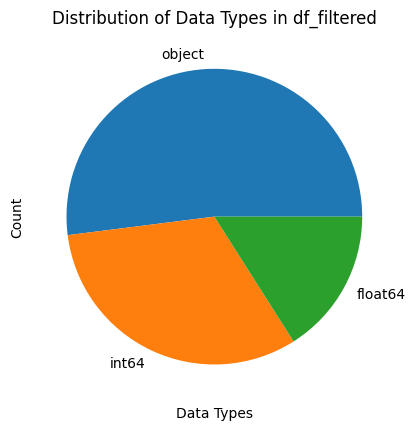

In [101]:
import matplotlib.pyplot as plt

# Get the count of each data type
dtype_counts = df_filtered.dtypes.value_counts()

# Plot a bar chart of the data types
dtype_counts.plot(kind='pie')
plt.xlabel("Data Types")
plt.ylabel("Count")
plt.title("Distribution of Data Types in df_filtered")
plt.show()


the following values can be converted to proper datatype with int and float

1. term
2. int_rate

2.  emp_length
2.   revol_util




In [102]:
# Clean 'int_rate' column (remove '%' and convert to float)
if df_filtered['int_rate'].dtype != 'float64':  # Check if it's not already cleaned
    df_filtered['int_rate'] = df_filtered['int_rate'].str.rstrip('%').astype(float)
if df_filtered['term'].dtype != 'int64'  :  # Check if it's not already cleaned
        df_filtered['term'] = df_filtered['term'].str.extract('(\d+)')[0].astype('int64')
df_filtered['emp_length'] = df_filtered['emp_length'].astype('int64')
if df_filtered['revol_util'].dtype != 'float64':  # Check if it's not already cleaned
    df_filtered['revol_util'] = df_filtered['revol_util'].str.rstrip('%').astype(float)

In [103]:
# Identifying variables with Numerical datatype
df_filtered.dtypes[df_filtered.dtypes.apply(lambda x: x == 'int64' or x == 'float64')]
# aCheck what are of Object datatype
df_filtered.dtypes[df_filtered.dtypes.apply(lambda x: x == 'object' )]


,0
grade,object
sub_grade,object
emp_title,object
home_ownership,object
verification_status,object
loan_status,object
purpose,object
zip_code,object
addr_state,object
last_pymnt_d,object


In [104]:
# Transofrm object dtypes to category type

# Convert object columns to category type
for column in df_filtered.select_dtypes(include=['object']):
  df_filtered[column] = df_filtered[column].astype('category')

# Convert term  wth int 64  to category dtype
# since term is 36 /60 it can be category variable
df_filtered['term'] = df_filtered['term'].astype('category')

In [105]:

df_filtered['last_pymnt_d'] = pd.to_datetime(df_filtered['last_pymnt_d'], format='%b-%y')
# creating a new type metric from date column
df_filtered['month_last_pymnt'] = df_filtered['last_pymnt_d'].dt.strftime("%b")


**END** of Data Cleaning


## Univariate Analysis


Filtering only Charged off information to do analysis

In [106]:
df_filtered = df_filtered[df_filtered['loan_status']!='Current']

In [107]:
df_filtered_charged =df_filtered[df_filtered['loan_status']=='Charged Off']

In [108]:
df_filtered_charged.describe()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_d,pub_rec_bankruptcies
count,5627.000000,5627.000000,5627.000000,5627.000000,5.627000e+03,5627.000000,5627.000000,5627.000000,5627.000000,5627.000000,5627.000000,5611.000000,5627.000000,5556,5627.000000
mean,12104.385108,13.820432,336.175006,5.037142,6.242730e+04,14.000624,0.170606,1.058113,9.178070,0.084770,13514.243647,55.572110,21.427581,2012-07-04 06:35:14.902807808,0.065754
min,900.000000,5.420000,22.790000,0.000000,4.080000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2008-03-01 00:00:00,0.000000
25%,5600.000000,11.310000,168.555000,2.000000,3.700000e+04,9.050000,0.000000,0.000000,6.000000,0.000000,3968.000000,34.400000,13.000000,2011-09-01 00:00:00,0.000000
50%,10000.000000,13.610000,293.870000,4.000000,5.300000e+04,14.290000,0.000000,1.000000,8.000000,0.000000,9211.000000,58.400000,20.000000,2012-07-01 00:00:00,0.000000
75%,16500.000000,16.400000,457.840000,9.000000,7.500000e+04,19.290000,0.000000,2.000000,12.000000,0.000000,17518.000000,79.000000,28.000000,2013-07-01 00:00:00,0.000000
max,35000.000000,24.400000,1305.190000,10.000000,1.250000e+06,29.850000,8.000000,8.000000,38.000000,2.000000,148829.000000,99.900000,74.000000,2016-04-01 00:00:00,2.000000
std,8085.732038,3.654413,217.051841,3.534031,4.777601e+04,6.585577,0.534986,1.154136,4.525937,0.284873,15164.117475,27.905282,11.447427,NaN,0.249304


In [109]:
 # In the Given data we need to Focus On Charged Off Applications .

# Util functions

In [110]:
def univariate_analysis_multi(df, column_names,hue='loan_status'):
    """
    Perform univariate analysis on multiple columns of a DataFrame.
    Plots histograms and boxplots for each column, and prints distribution metrics in a table format.

    Parameters:
    df (DataFrame): The input DataFrame.
    column_names (list): A list of column names for analysis.
    """

    # Create a list to store distribution metrics for each column
    all_metrics = []

    # Loop through each column name
    for column_name in column_names:
        # Drop missing values for the analysis
        column_data = df[column_name].dropna()

        # Calculate distribution metrics
        mean_val = column_data.mean()
        median_val = column_data.median()
        std_dev = column_data.std()
        skewness = column_data.skew()
        kurtosis = column_data.kurt()

        # Store metrics in a dictionary
        metrics = {
            'Column': column_name,
            'Mean': mean_val,
            'Median': median_val,
            'Std Dev': std_dev,
            'Skewness': skewness,
            'Kurtosis': kurtosis
        }
        all_metrics.append(metrics)

        # Set up the figure and subplots
        plt.figure(figsize=(12, 6))



        df['loan_status'] = df['loan_status'].cat.remove_unused_categories()

        # Set up the figure and subplots
        plt.figure(figsize=(12, 6))

        # First subplot: Histogram with KDE
        plt.subplot(1, 2, 1)
        sns.histplot(df, x=column_name, hue=hue, kde=True, bins=30)
        plt.title(f'Histogram of {column_name} by {hue}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')



        # Second subplot: Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=column_data,x=df[hue],hue_order=['Fully Paid','Charged Off'] ,color='green')
        plt.title(f'Boxplot of {column_name}')

        # Display the plots
        plt.tight_layout()
        plt.show()

    # Create a DataFrame from the collected metrics and display it as a table
    metrics_df = pd.DataFrame(all_metrics)
    display(metrics_df)

def univariate_analysis(df, column_name, hue='loan_status'):
    """
    Perform univariate analysis on a specific column of a DataFrame.
    Plots a histogram and a boxplot, and prints distribution metrics like mean, median, skewness, kurtosis, etc.

    Parameters:
    df (DataFrame): The input DataFrame.
    column_name (str): The name of the column for analysis.
    """

    # Drop missing values for the analysis
    column_data = df[column_name].dropna()

    # Calculate distribution metrics
    mean_val = column_data.mean()
    median_val = column_data.median()
    std_dev = column_data.std()
    skewness = column_data.skew()
    kurtosis = column_data.kurt()
    df['loan_status'] = df['loan_status'].cat.remove_unused_categories()

    # Print distribution metrics
    print(f"--- Distribution Metrics for {column_name} ---")
    print(f"Mean: {mean_val}")
    print(f"Median: {median_val}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    print("\n")

    # Set up the figure and subplots
    plt.figure(figsize=(12, 6))

    # First subplot: Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df, x=column_name, hue=hue, kde=True, bins=30)
    plt.title(f'Histogram of {column_name} by {hue}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')



    # Second subplot: Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=column_data,x=df[hue],hue_order=['Fully Paid','Charged Off'] ,color='green')
    plt.title(f'Boxplot of {column_name}')


    # Display the plots
    plt.tight_layout()
    plt.show()

def UVA_category(data, columns_list):
    """
    Perform univariate analysis on multiple categorical variables.

    Parameters:
    - data: DataFrame containing the data
    - columns_list: list of str, names of the categorical columns to analyze

    Outputs:
    - Frequency table and count plot of each column's value distribution, shown in rows of two columns each.
    """
    for i, column_name in enumerate(columns_list):
        # Check if column exists
        if column_name not in data.columns:
            print(f"Column '{column_name}' not found in the DataFrame.")
            continue

        # Generate frequency table
        frequency_table = data[column_name].value_counts()
        # Plot count plot with two figures in each row
        plt.figure(figsize=(15, 6))

        # Left plot: Count plot
        plt.subplot(1, 2, 1)
        sns.countplot(data=data, x=column_name, order=frequency_table.index, hue='loan_status', palette="viridis")
        plt.title(f"Count Plot for '{column_name}'")
        plt.xticks(rotation=45)
        plt.xlabel(column_name)
        plt.ylabel("Count")


        plt.tight_layout()
        plt.show()

###  Univariate Analysis: Numerical Variables

In [111]:
# Extract numerical varaiables
selected_df = df_filtered_charged.select_dtypes(include=['int64', 'float64'])
selected_df.columns
# univariate_analysis_multi(df_filtered_charged, selected_df.columns)

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'pub_rec_bankruptcies'],
      dtype='object')

### Loan Amount

We can see loan amount in range 5600-16500  where most people have taken loan which is 50%





<ipython-input-110-ff623779b697>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].cat.remove_unused_categories()


--- Distribution Metrics for loan_amnt ---
Mean: 11047.02542966016
Median: 9600.0
Standard Deviation: 7348.441646312195
Skewness: 1.0781026597810632
Kurtosis: 0.8429524525755574




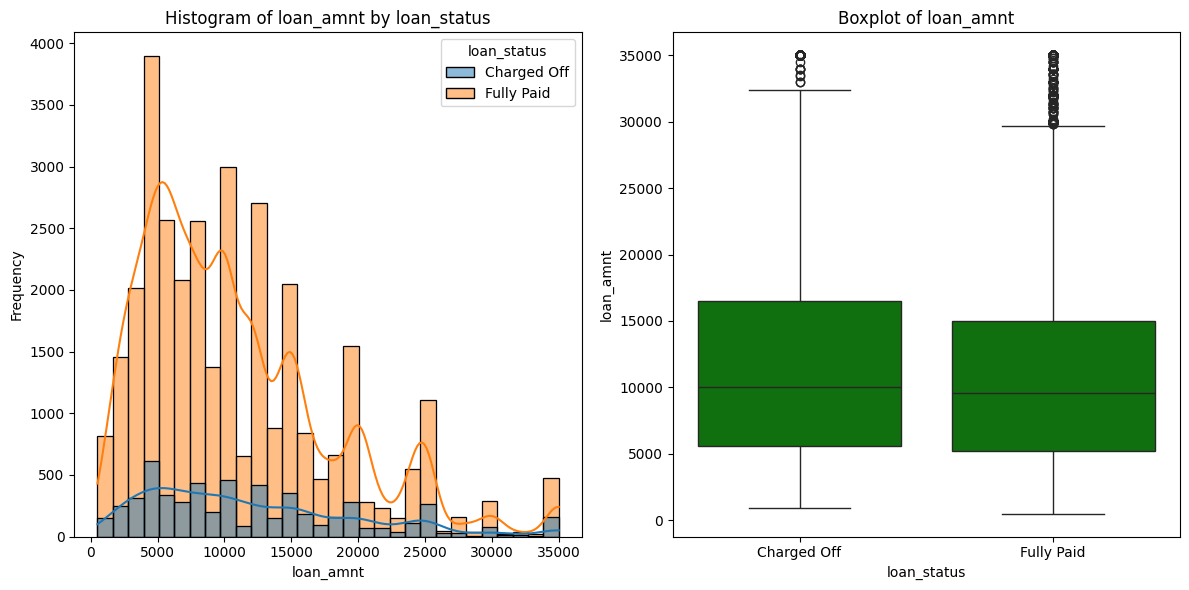

,loan_amnt
count,5627.000000
mean,12104.385108
std,8085.732038
min,900.000000
25%,5600.000000
50%,10000.000000
75%,16500.000000
max,35000.000000


In [112]:
univariate_analysis(df_filtered,selected_df.columns[0])
df_filtered_charged["loan_amnt"].describe()

This shows that most of defaulters are taking smaller loan amounts in range (5000-16000)  and max value is 35000

### Binning loan Amount (segmentation analyis)

<ipython-input-113-989a129c6378>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_charged['loan_amount_category'] = pd.cut(df_filtered_charged['loan_amnt'], bins=bins, labels=labels, include_lowest=True)


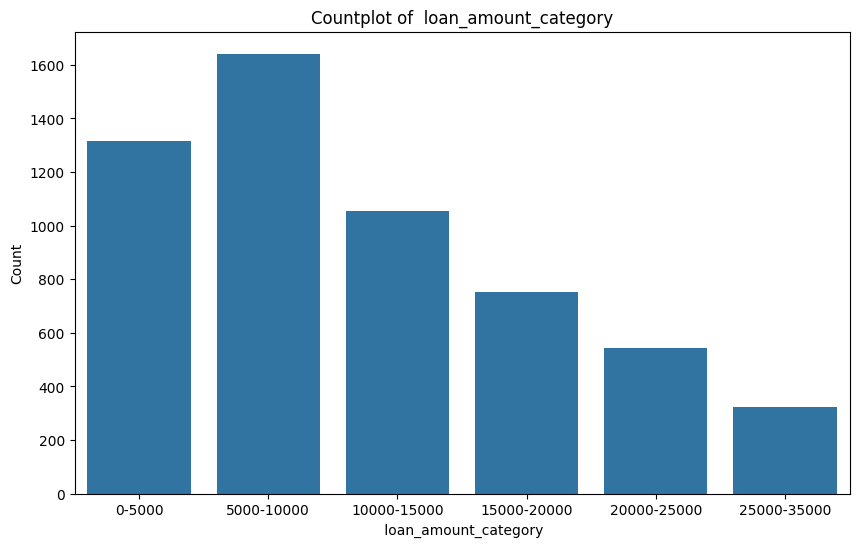

In [113]:

# Create bins for loan amount
bins = [0, 5000, 10000, 15000, 20000, 25000, 35000]
labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000', '25000-35000']

# Use pd.cut to categorize loan amount into bins
df_filtered_charged['loan_amount_category'] = pd.cut(df_filtered_charged['loan_amnt'], bins=bins, labels=labels, include_lowest=True)

# Perform univariate analysis on the loan amount category
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_amount_category', data=df_filtered_charged)
plt.title('Countplot of  loan_amount_category')
plt.xlabel(' loan_amount_category')
plt.ylabel('Count')
plt.show()

#### Interest rate

--- Distribution Metrics for int_rate ---
Mean: 11.93221867952407
Median: 11.71
Standard Deviation: 3.6913274251360737
Skewness: 0.2936268439021733
Kurtosis: -0.4472800238277723




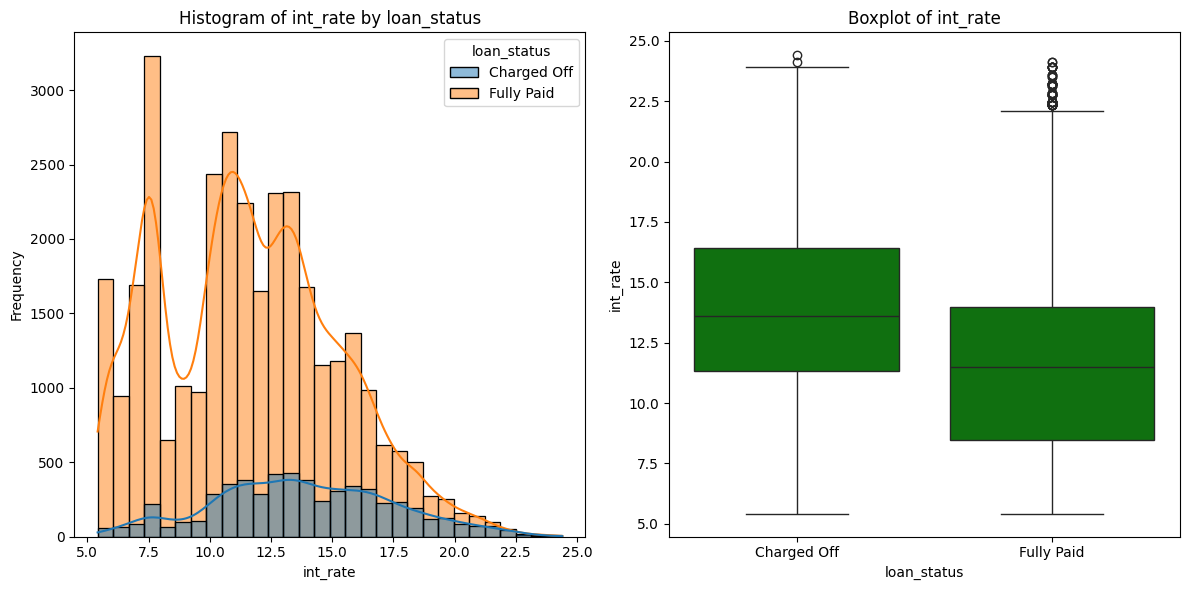

In [114]:
univariate_analysis(df_filtered,'int_rate')

From the Graph we can see some of them got very low interset rates
But the average rate is 13


1. **Interest Rate Distribution**:
   - The interest rates for charged-off applicants are not uniformly distributed.
   - There is a concentration of interest rates around the middle range, suggesting that a significant number of charged-off applicants have interest rates and also Interest for CHargedoff Loans is higher than Full paid

3. **Outliers**:
   - The presence of outliers in the box plot suggests that there are some charged-off applicants with interest rates significantly higher or lower than the majority.
   - These outliers could be of interest for further investigation to understand the reasons behind these extresi

--- Distribution Metrics for installment ---
Mean: 322.466318013324
Median: 277.86
Standard Deviation: 208.63921453588583
Skewness: 1.150486497077771
Kurtosis: 1.3179975210820816




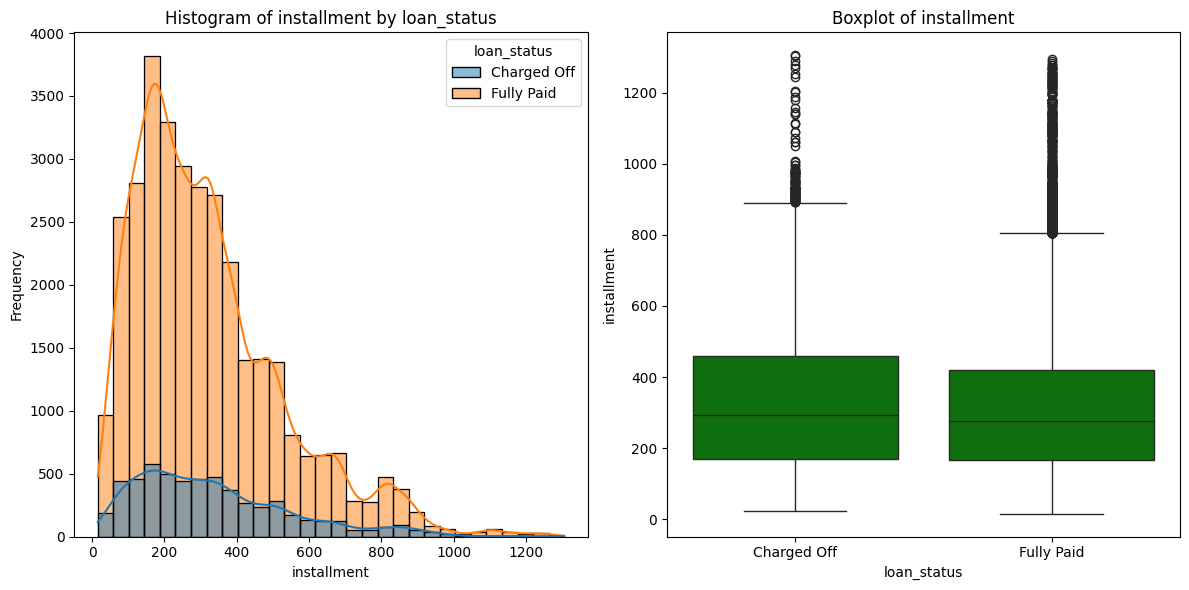

In [115]:
univariate_analysis(df_filtered,'installment')


But the average Installment value is 293 (taking median since they are outliers)


1. **Installment Values Distribution**:
   - The interest rates for charged-off applicants are not uniformly distributed.
   - There is a concentration of Installment rates around the lower range, suggesting that a significant number of charged-off applicants have Installment rates in this range (200-450)
   - This indicates that most peole try to choose the less installment rate for thier given loan aount (like increasing  the no of months term)
This we can understand more in bivariate



### emp_length

--- Distribution Metrics for emp_length ---
Mean: 4.915778831946497
Median: 4.0
Standard Deviation: 3.5124185881039853
Skewness: 0.2367239152278886
Kurtosis: -1.3099869638468644




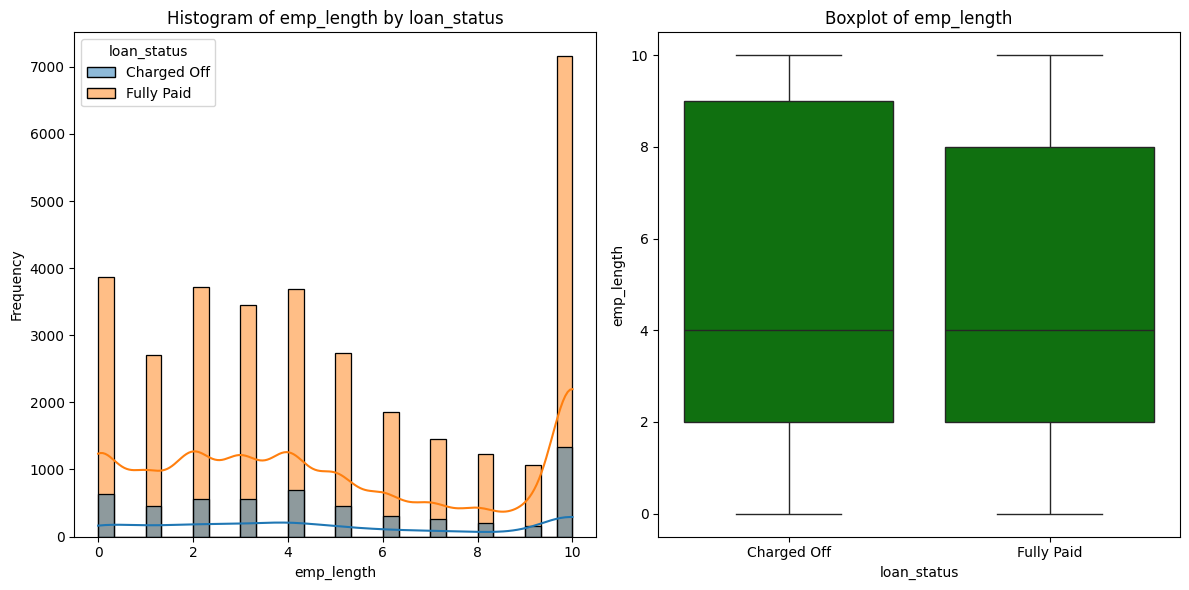

In [116]:
univariate_analysis(df_filtered,'emp_length')


1. **emp_length  Values Distribution**:
-  There is a high frequency of values at 0 years and 10 years, suggesting that many applicants either have no employment history or have been employed for 10 or more years.

### annual_inc

--- Distribution Metrics for annual_inc ---
Mean: 68777.97368120901
Median: 58868.0
Standard Deviation: 64218.68180165151
Skewness: 31.198413742356554
Kurtosis: 2308.775185814982




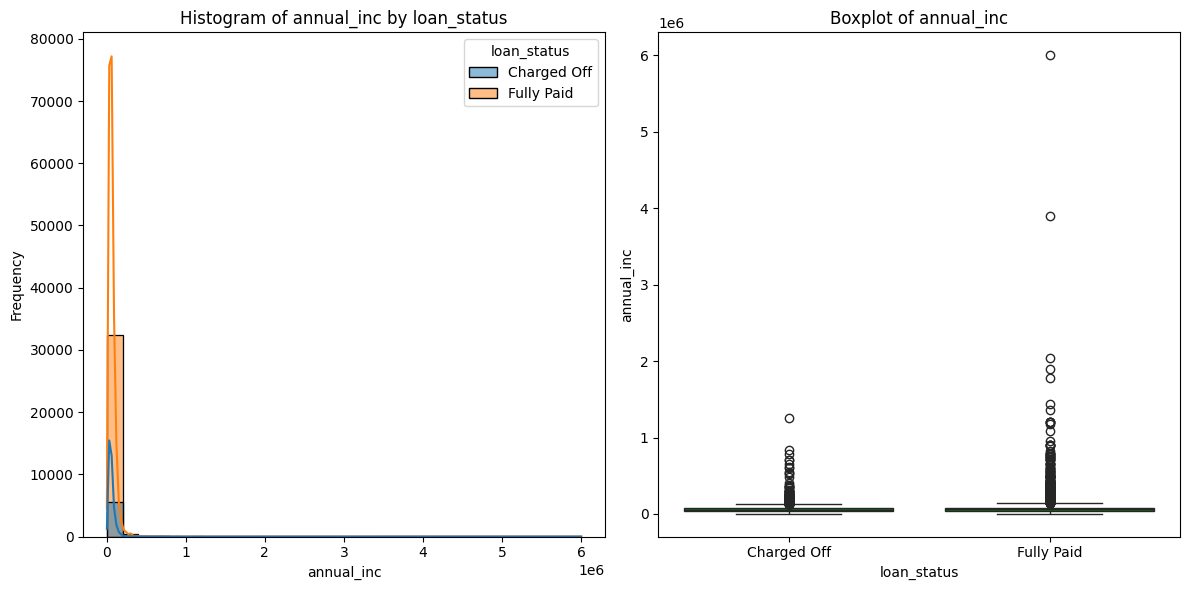

,annual_inc
count,5.627000e+03
mean,6.242730e+04
std,4.777601e+04
min,4.080000e+03
25%,3.700000e+04
50%,5.300000e+04
75%,7.500000e+04
max,1.250000e+06


In [117]:
univariate_analysis(df_filtered,selected_df.columns[4])
df_filtered_charged["annual_inc"].describe()

<ipython-input-118-be1647b32b66>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_charged['annual_inc_category'] = pd.cut(df_filtered_charged['annual_inc'], bins=bins, labels=labels, include_lowest=True)


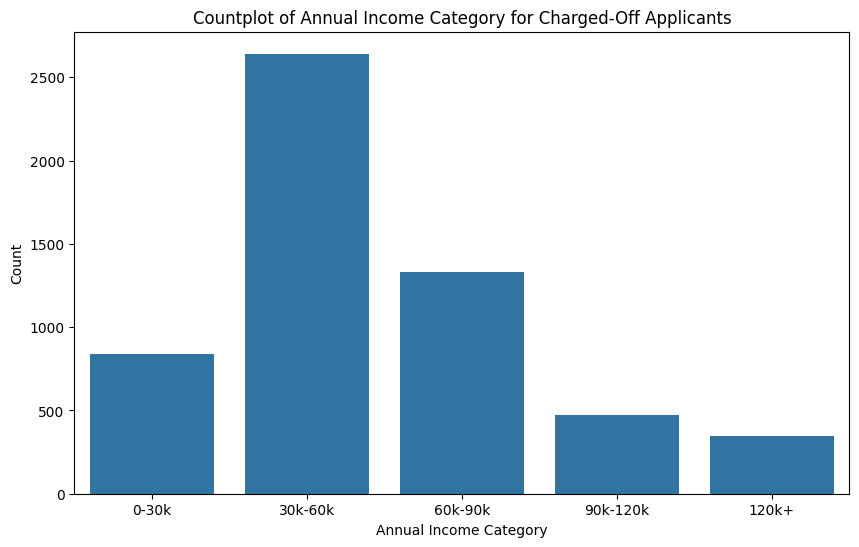

In [118]:
#  bin the annual inc for size  30k bins label to remove the affect of iutliers


# Define bins and labels for annual income
bins = [0, 30000, 60000, 90000, 120000, float('inf')]
labels = ['0-30k', '30k-60k', '60k-90k', '90k-120k', '120k+']

#  pd.cut to categorize annual income into bins
df_filtered_charged['annual_inc_category'] = pd.cut(df_filtered_charged['annual_inc'], bins=bins, labels=labels, include_lowest=True)

# Perform univariate analysis on the annual income category
plt.figure(figsize=(10, 6))
sns.countplot(x='annual_inc_category', data=df_filtered_charged)
plt.title('Countplot of Annual Income Category for Charged-Off Applicants')
plt.xlabel('Annual Income Category')
plt.ylabel('Count')
plt.show()

Most of defaultors were in low range of annual inc ,this is Negative Correlation
so this is a strong indicator were 50% of people income is below 60000

--- Distribution Metrics for dti ---
Mean: 13.272727013505456
Median: 13.37
Standard Deviation: 6.67304429909655
Skewness: -0.026842422406298073
Kurtosis: -0.8562980092513257




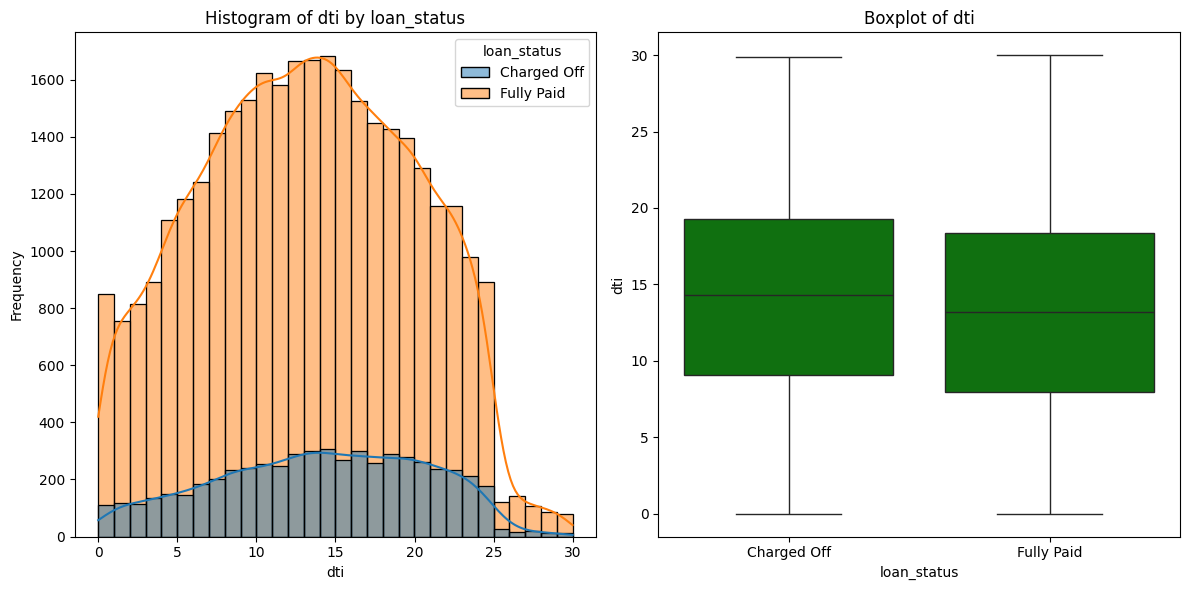

In [119]:
univariate_analysis(df_filtered,selected_df.columns[5])


DTI  is Perfectly Distributed
Debt to income ratio avergae is near to 15% where max being 30%


--- Distribution Metrics for inq_last_6mths ---
Mean: 0.87173704538974
Median: 1.0
Standard Deviation: 1.0715456845123013
Skewness: 1.384389797513499
Kurtosis: 2.5244379869572793




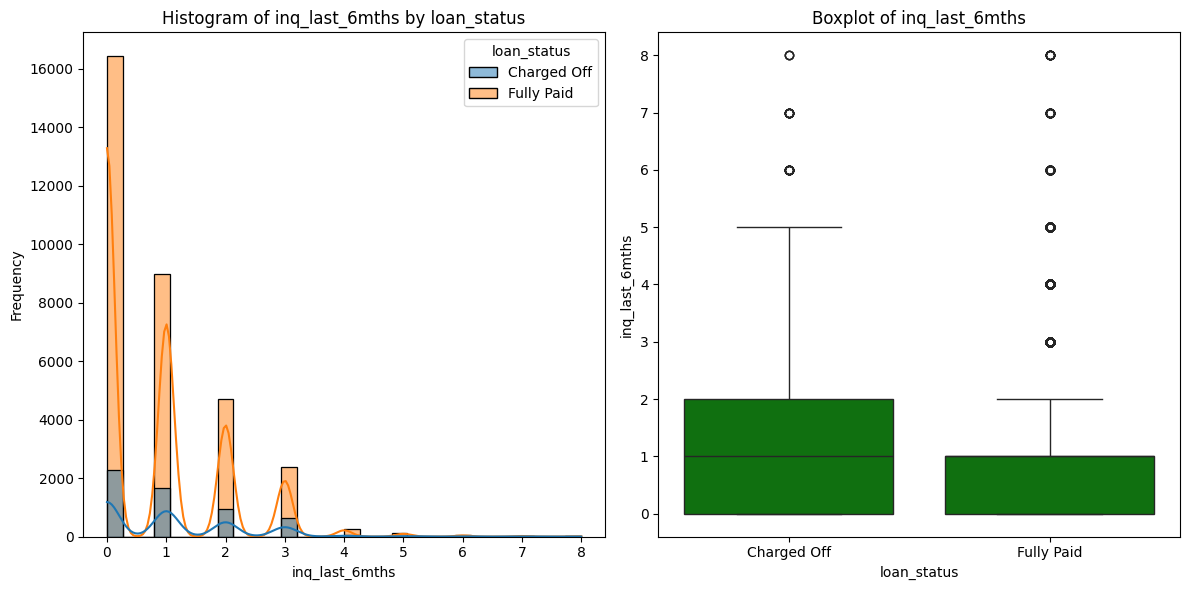

In [120]:
univariate_analysis(df_filtered,selected_df.columns[7])

From boxplot we can Analyze
Around 50% of defaulters have got an inquiry >1


<Figure size 1200x600 with 0 Axes>

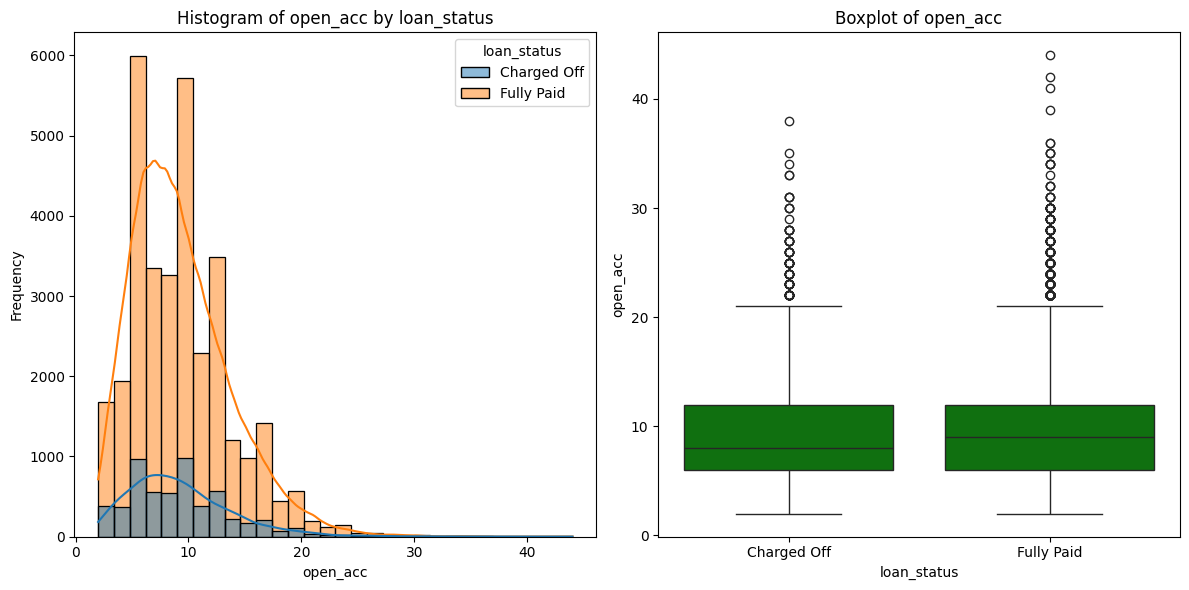

<Figure size 1200x600 with 0 Axes>

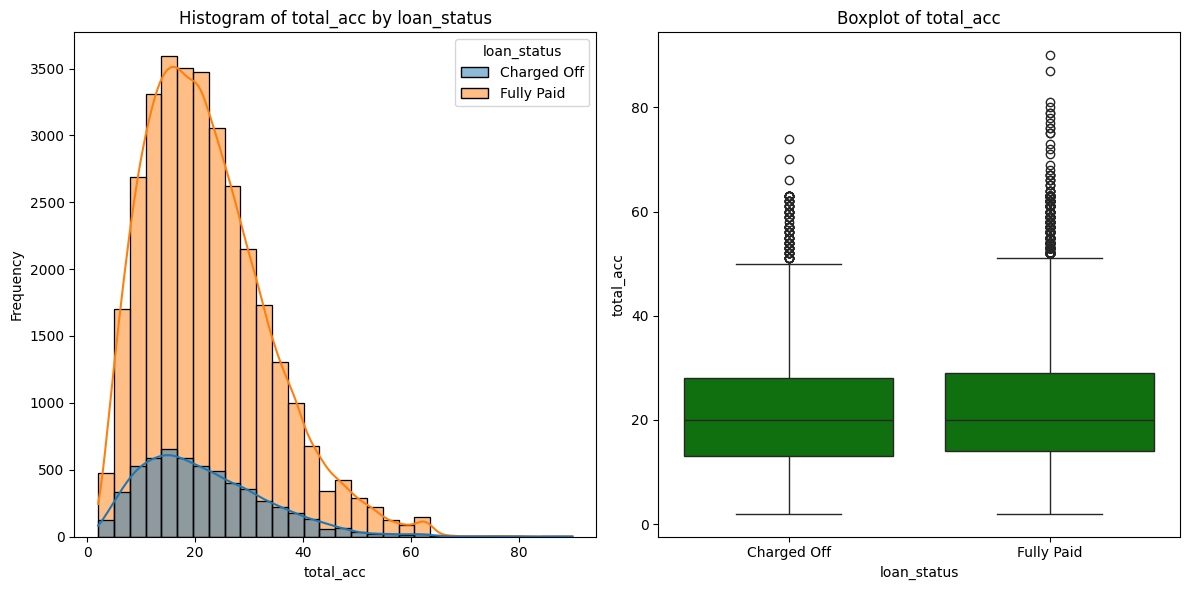

,Column,Mean,Median,Std Dev,Skewness,Kurtosis
0,open_acc,9.275423,9.0,4.401588,1.007288,1.693960
1,total_acc,22.052648,20.0,11.425861,0.832481,0.700523


In [121]:
univariate_analysis_multi(df_filtered,['open_acc', 'total_acc'])


##  Total Accounts
Credit-Active Borrowers: The data suggests that a large portion of borrowers(who are defaulters) are actively using credit, as evidenced by the high number of credit lines.
Potential Risk: While a higher number of credit lines might indicate a good credit profile, it could also signal potential risk if not managed well. Lenders might need to consider this factor when assessing creditworthiness.

The histogram for open_acc
The number of open credit lines in the borrower's credit file.
## Open Accounts

- The plot shows that most individuals have a relatively low number of open accounts, with the peak occurring around 6-7 accounts. This suggests that a significant portion of the population is responsible with their credit usage and avoids excessive credit accumulation.


<ipython-input-122-62629c7bbce6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_charged['total_acc_category'] = pd.cut(df_filtered_charged['total_acc'], bins=bins, labels=labels, include_lowest=True)


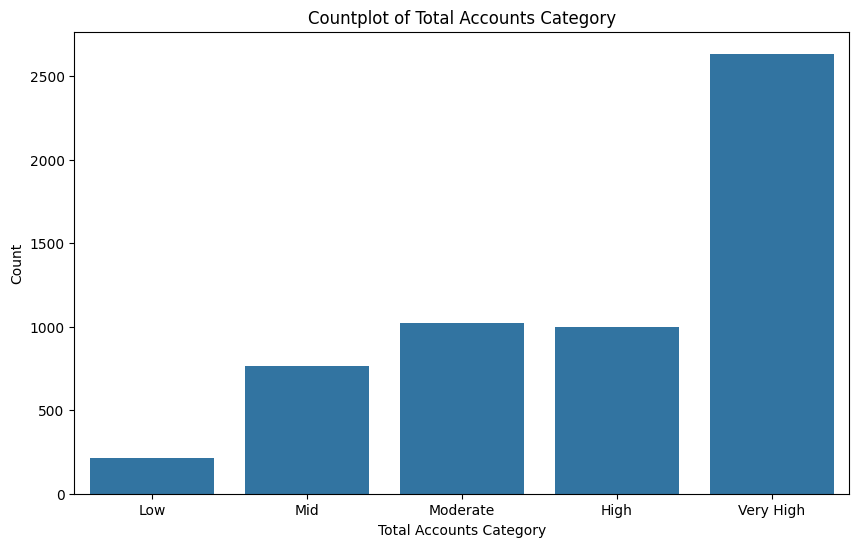

In [122]:
#  we bin the total_account to 5 segments like low mid high etcc and analyze  the count plots since there are few outlier

# Create bins for total_acc
bins = [0, 5, 10, 15, 20, float('inf')]  # Adjust bin edges as needed
labels = ['Low', 'Mid', 'Moderate', 'High', 'Very High']

# Use pd.cut to categorize total_acc into bins
df_filtered_charged['total_acc_category'] = pd.cut(df_filtered_charged['total_acc'], bins=bins, labels=labels, include_lowest=True)

# Perform univariate analysis on the total_acc category
plt.figure(figsize=(10, 6))
sns.countplot(x='total_acc_category', data=df_filtered_charged)
plt.title('Countplot of Total Accounts Category')
plt.xlabel('Total Accounts Category')
plt.ylabel('Count')
plt.show()

From this we can Categorize that as Category class is increasing the default rate is increasing so the biininghere helped us to bin the customers based on the number of accounts




from delinq_2yrs we cant derive important info  ffrom this since this data is zero for most *of* the borrowers ,so we cant deduce any borrower's financial reliability


## 'pub_rec and  'pub_rec_bankruptcies'

<Figure size 1200x600 with 0 Axes>

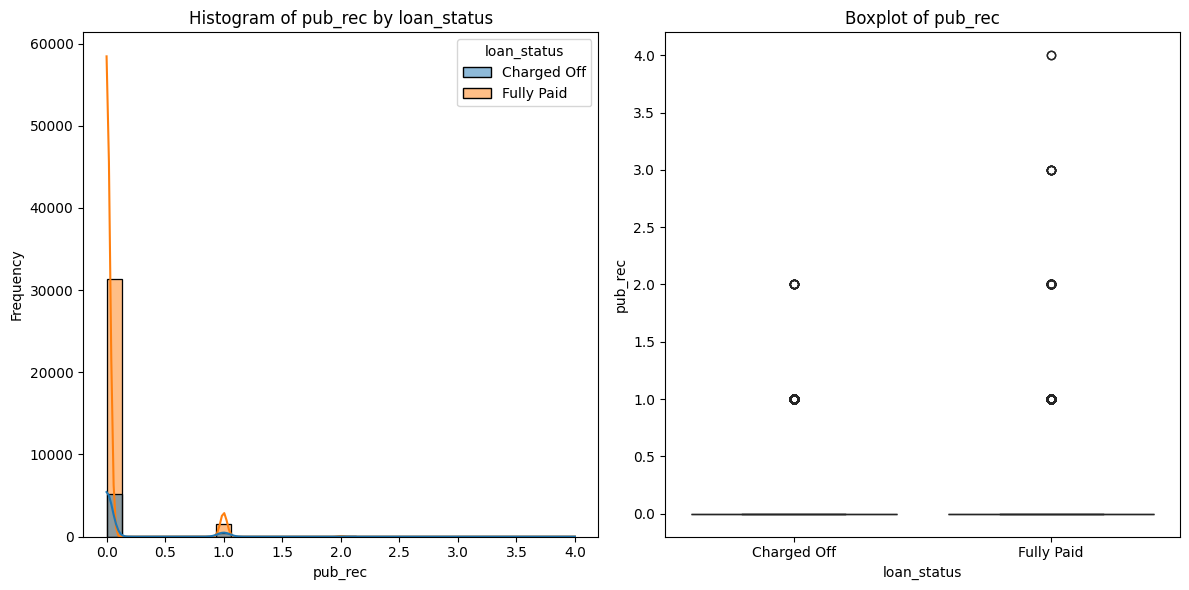

<Figure size 1200x600 with 0 Axes>

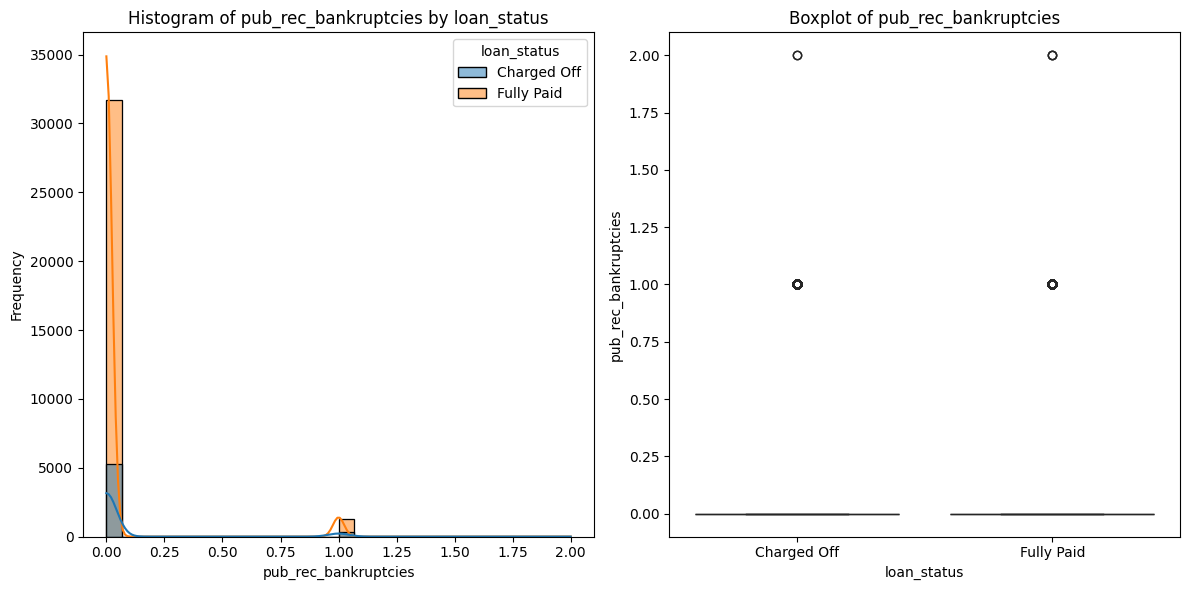

<Figure size 1200x600 with 0 Axes>

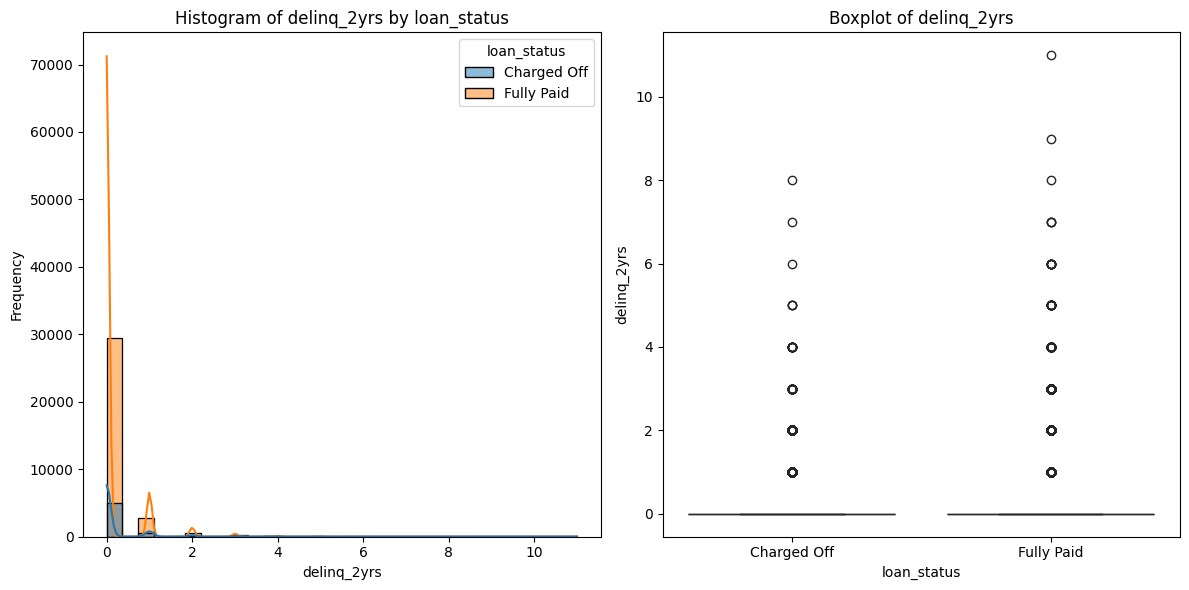

,Column,Mean,Median,Std Dev,Skewness,Kurtosis
0,pub_rec,0.055422,0.0,0.237804,4.519991,23.750596
1,pub_rec_bankruptcies,0.042694,0.0,0.202809,4.570792,19.195880
2,delinq_2yrs,0.146668,0.0,0.492271,5.033279,39.727336


In [123]:
univariate_analysis_multi(df_filtered, ['pub_rec', 'pub_rec_bankruptcies','delinq_2yrs'])

## Revolving balance
The majority of customers exhibit lower revolving balances, and the frequency of these balances decreases as the balance amount increases. This suggests that larger balances are less common among our customer base. However, we've observed some outlier cases with unusually high revolving balances. Implementing a binning strategy could help us segment these outliers and analyze them separately, potentially revealing valuable insights into their behavior and risk profiles
Also from the graph we can see the Reolving balance lesst than 20 k morelike to default by 75% chances



--- Distribution Metrics for revol_bal ---
Mean: 13289.489825543718
Median: 8762.0
Standard Deviation: 15866.492240857586
Skewness: 3.2120193503036956
Kurtosis: 15.048866701739417




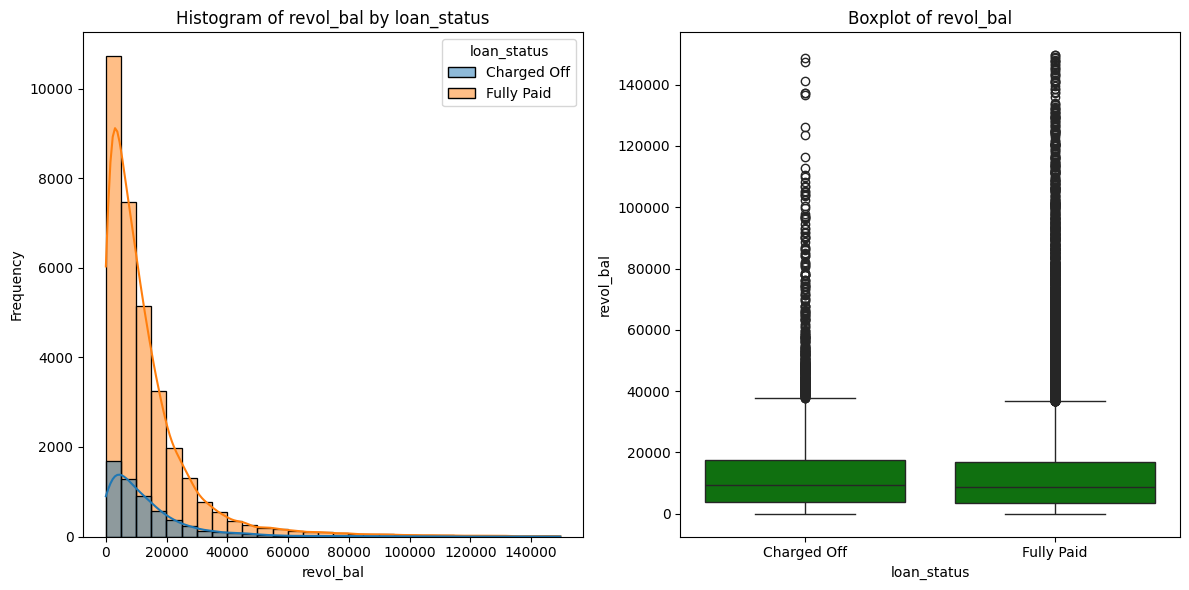

In [124]:
univariate_analysis(df_filtered,'revol_bal')


## Revolving Utilisation
We observe a clear pattern where the loan default rate increases as the revolving utilization rate rises.  75% of defaulters have a utilization rate in range below 80 % .
- Additionally, there’s a distinct spike in defaults at a 0% utilization rate, indicating a need to analyze its relationship with other factors to understand its impact on defaults.

--- Distribution Metrics for revol_util ---
Mean: 48.702776753964756
Median: 49.1
Standard Deviation: 28.364741182389448
Skewness: -0.02756857193054275
Kurtosis: -1.1083543539980716




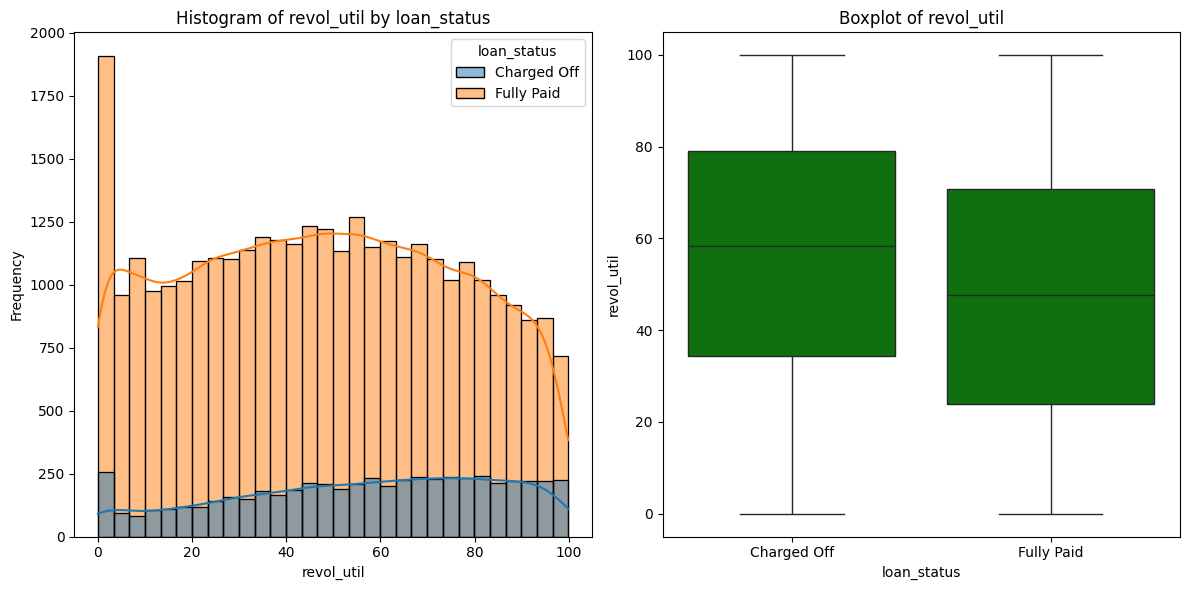

In [125]:
univariate_analysis(df_filtered,'revol_util')


# **Summary**
Decisive Factor whether an applicant will be Defaulter:

1. Loan Amount : When Loan amount is lower in range 10-60k
2. Emp_length : When its too low or too high
3. Total Account of credits : When its high the default rate is high too
4. Revolving Utilisation : The  more the utilisation rate the more the default rate


# Categorical Variables


In [126]:
selected_df_categorical = df_filtered_charged.select_dtypes(include=['category'])
selected_df_categorical.columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'loan_amount_category', 'annual_inc_category',
       'total_acc_category'],
      dtype='object')

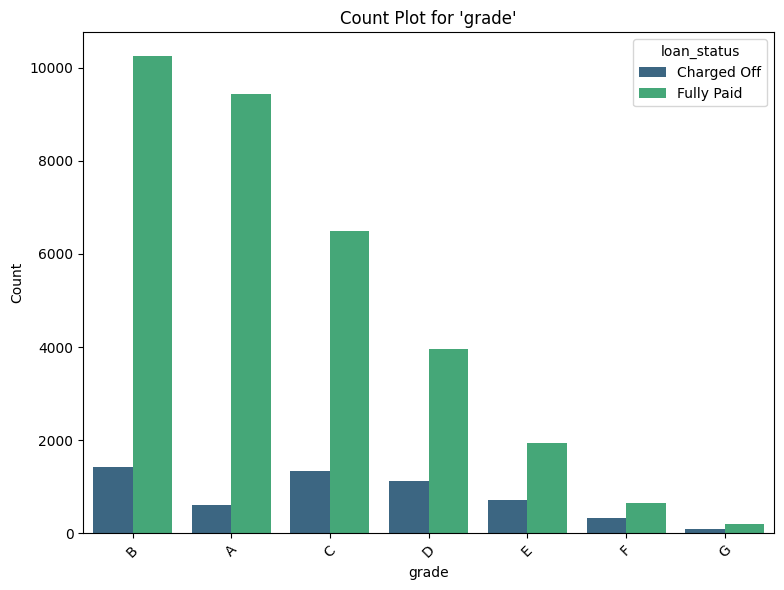

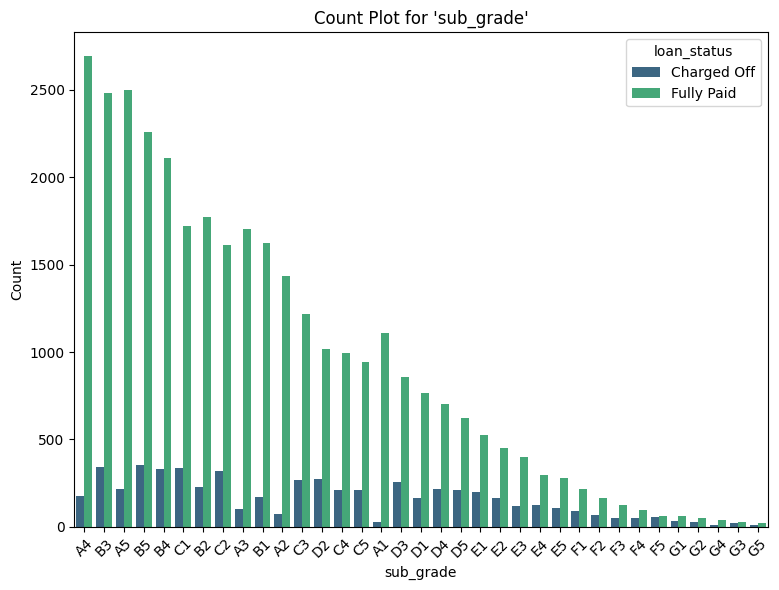

In [127]:
categorical = ['grade','sub_grade']
UVA_category(df_filtered,categorical)

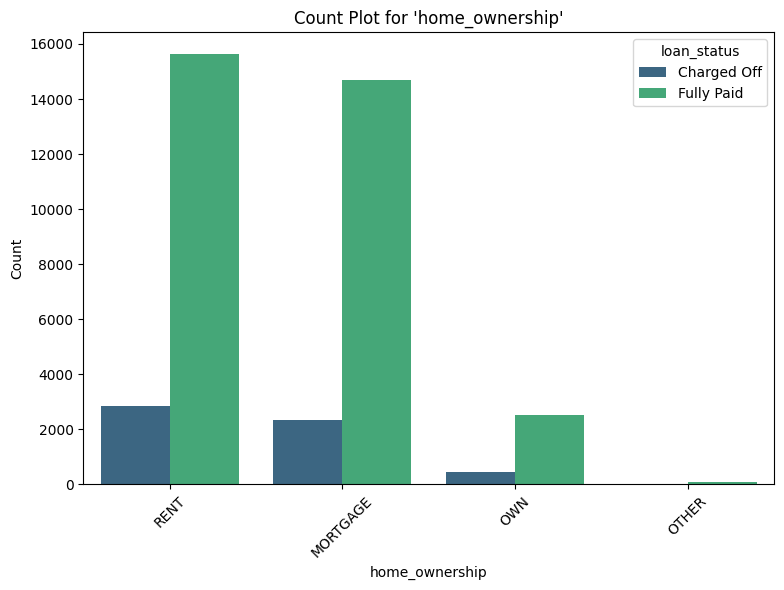

In [128]:
UVA_category(df_filtered,['home_ownership'])

In [129]:
# 1. grade
# Most of people are from  "B" & "C" grade
# 2. Home ownership
# Majority of them dont own houses either having Mortgate or staying in rent
# 3. Verification
# Its almost equal distributed  between verified and Not verified
# 4. Title
# Clearlyall of them  have opted with loan_title as debt consolidation

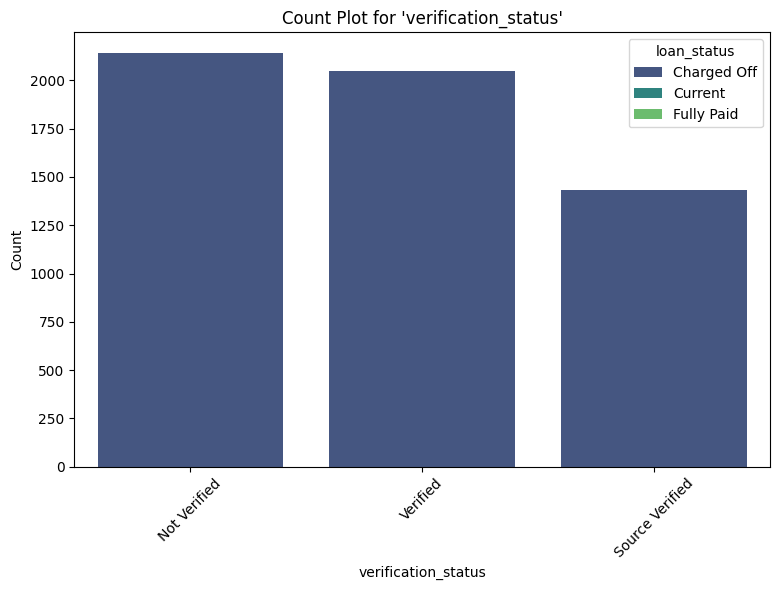

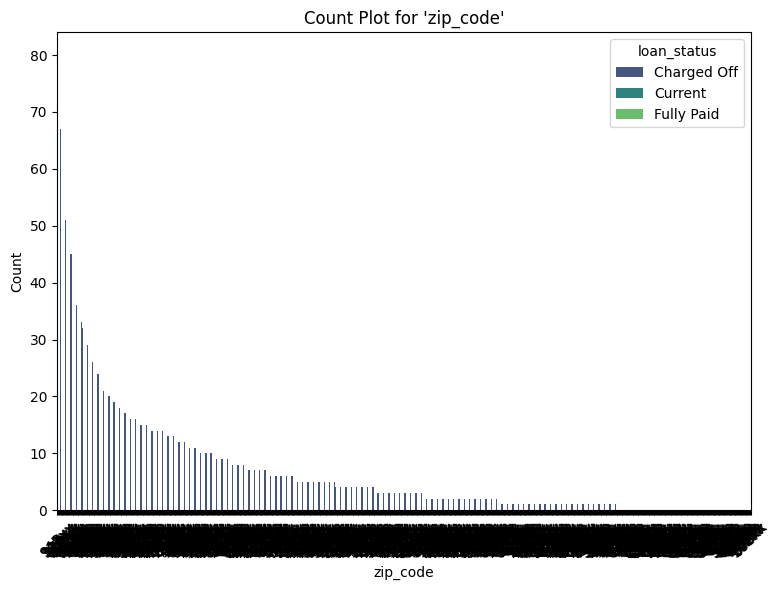

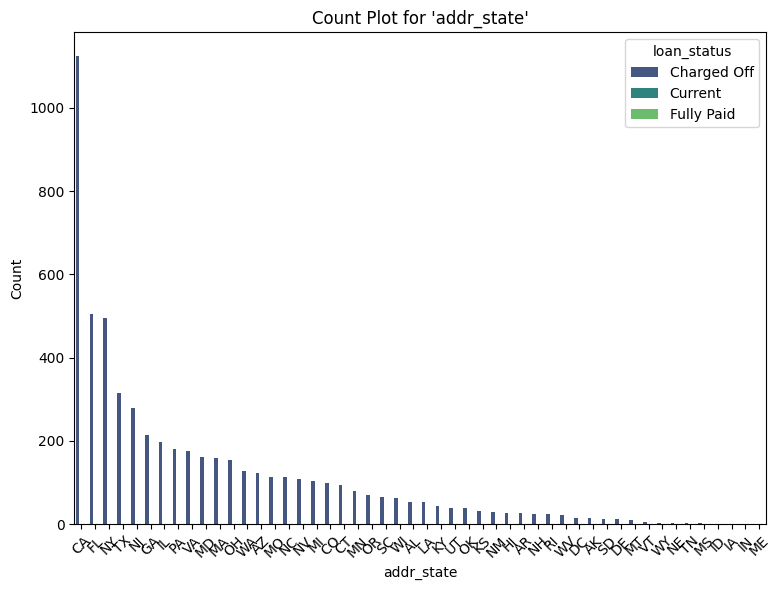

In [130]:
categorical = ['verification_status','zip_code','addr_state']
UVA_category(df_filtered_charged,categorical)

# 4. Zip code
# Its almost equal distributed  between them
# 5. Address State
# CA state is hvaing major borrowers who default which is 20%

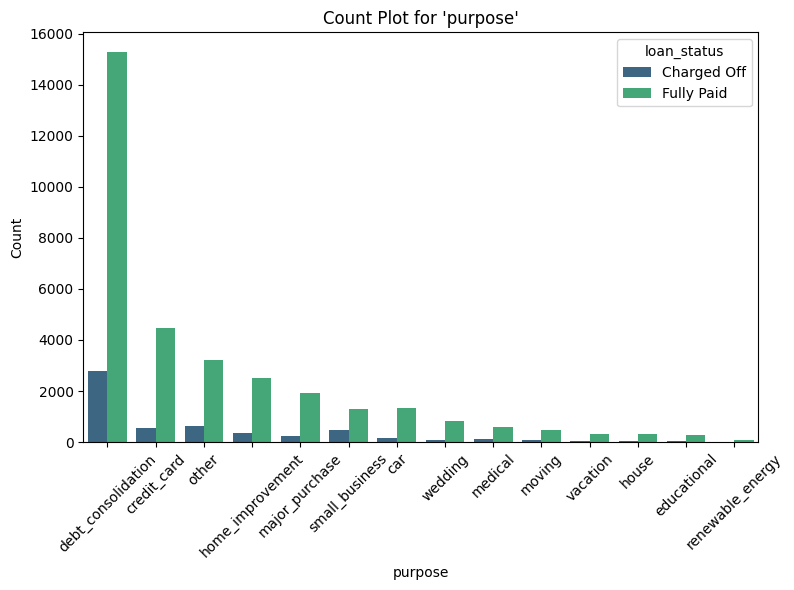

In [131]:
categorical = ['purpose']
UVA_category(df_filtered,categorical)

Debt Consolidation Purpose stands out in Default rate of

In [132]:

df_filtered['month_last_pymnt'] = df_filtered['last_pymnt_d'].dt.strftime("%b")
df_filtered_charged['month_last_pymnt'] = df_filtered_charged['last_pymnt_d'].dt.strftime("%b")

df_filtered_charged['month_last_pymnt'].value_counts()

<ipython-input-132-529bf1c0c414>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_charged['month_last_pymnt'] = df_filtered_charged['last_pymnt_d'].dt.strftime("%b")


,count
month_last_pymnt,
Oct,542
Jul,519
Dec,494
Sep,474
Jun,462
Aug,457
May,456
Apr,441
Jan,433


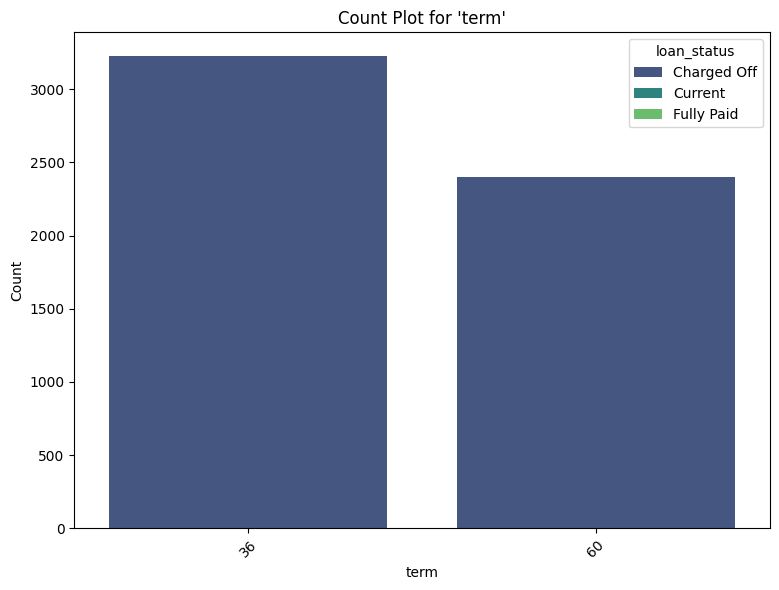

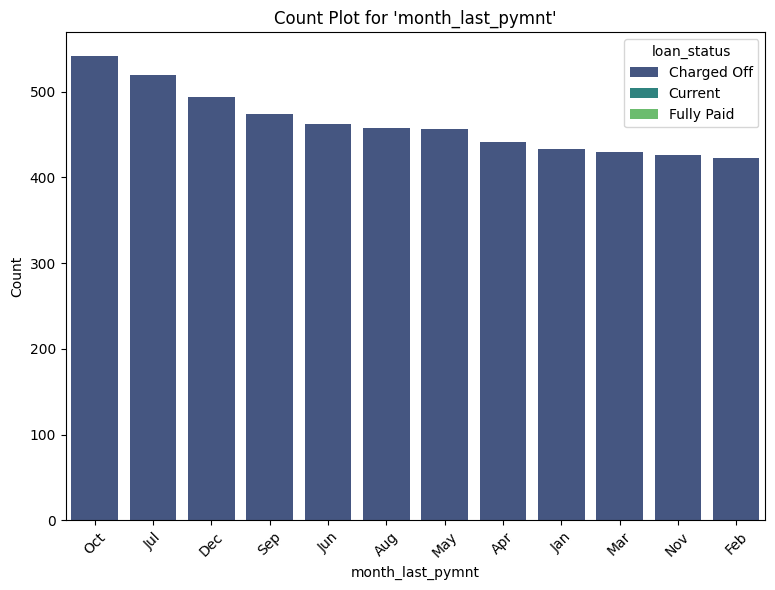

In [153]:
categorical = ['term','month_last_pymnt']
UVA_category(df_filtered_charged,categorical)


Loan issued Months of October and July received a higher default intakes




# Bivariate Analysis
 Understanding the relation of grade for charged off usecases relative to whole applicants for the grade

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_default_percentage(df, category_column, status_column, default_status='Charged Off'):
    """
    Plots the percentage of defaulted loans by a specified categorical column.

    This function groups the data by a specified categorical column (e.g., loan grade, purpose, or sub-grade) and loan status,
    counts the occurrences of each status within each category, and calculates the percentage of loans that are in the default status.
    The function then plots the percentage of defaults for each category value to help visualize default rates.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame containing the loan data.

    category_column : str
        The column name in `df` representing the categorical variable to group by (e.g., 'grade', 'purpose').

    status_column : str
        The column name in `df` representing the loan status (e.g., 'loan_status').

    default_status : str, optional
        The value in `status_column` that represents a defaulted loan (default is 'Charged Off').

    Returns:
    -------
    None
        Displays a bar plot of default percentages by the specified category and prints the loan status counts by category.

    """

    # Group the data by the specified category column and loan status, and count the number of occurrences
    loan_status_counts = df.groupby([category_column, status_column]).size().unstack(fill_value=0)

    # Calculate the percentage of defaults per category
    loan_status_counts['Default_Percent'] = (loan_status_counts[default_status] / loan_status_counts.sum(axis=1)) * 100

    # Display the result
    print(loan_status_counts)

    # Plot the percentage of defaults per category
    plt.figure(figsize=(10, 6))
    sns.barplot(x=loan_status_counts.index, y=loan_status_counts['Default_Percent'], color='skyblue')

    # Add labels and title
    plt.title(f'Percentage of Defaulted Loans by {category_column.capitalize()}')
    plt.xlabel(category_column.capitalize())
    plt.ylabel('Default Percentage (%)')

    # Display the plot
    plt.show()

# Example usage


<ipython-input-134-62e2025697c0>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_status_counts = df.groupby([category_column, status_column]).size().unstack(fill_value=0)


loan_status  Charged Off  Fully Paid  Default_Percent
grade                                                
A                    602        9443         5.993031
B                   1425       10250        12.205567
C                   1347        6487        17.194281
D                   1118        3967        21.986234
E                    715        1948        26.849418
F                    319         657        32.684426
G                    101         198        33.779264


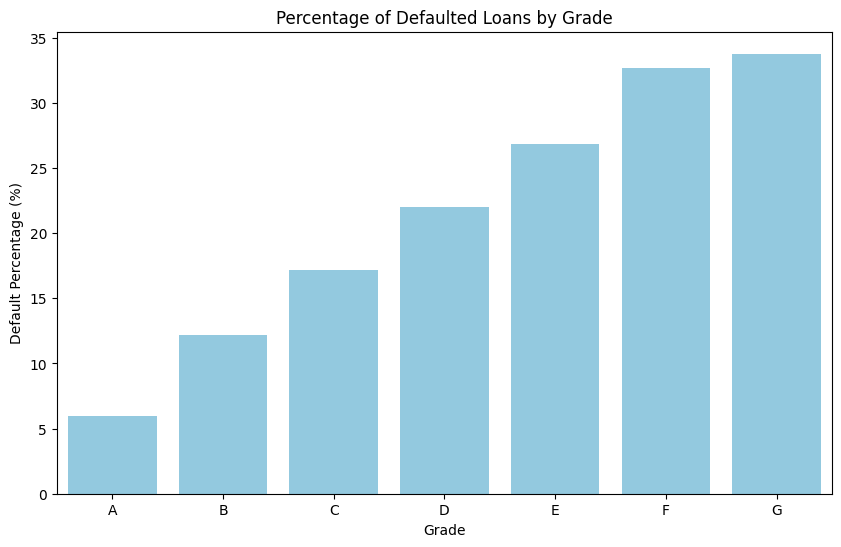

In [135]:
plot_default_percentage(df_filtered, 'grade', 'loan_status', 'Charged Off')


### we can clearly say Loan Grade is  decisive metric for Defaulted loans percentage when compared whole with the all apllicants in data




since % percentage of defaults is  increased  based on grade increase ,similary it applies to loan subgrade

<ipython-input-134-62e2025697c0>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_status_counts = df.groupby([category_column, status_column]).size().unstack(fill_value=0)


loan_status  Charged Off  Fully Paid  Default_Percent
sub_grade                                            
A1                    30        1109         2.633889
A2                    74        1434         4.907162
A3                   103        1707         5.690608
A4                   178        2695         6.195614
A5                   217        2498         7.992634
B1                   171        1626         9.515860
B2                   228        1773        11.394303
B3                   341        2484        12.070796
B4                   329        2108        13.500205
B5                   356        2259        13.613767
C1                   336        1719        16.350365
C2                   321        1610        16.623511
C3                   270        1218        18.145161
C4                   212         994        17.578773
C5                   208         946        18.024263
D1                   167         764        17.937701
D2                   271    

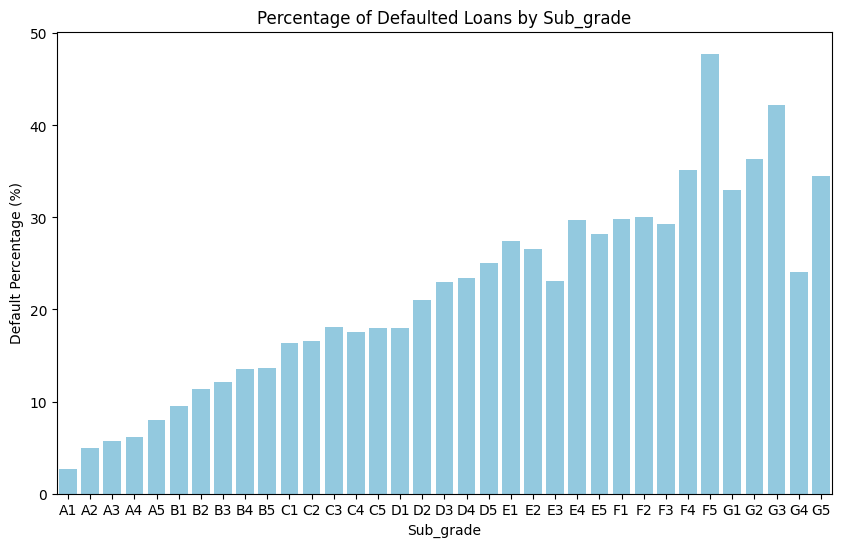

<ipython-input-134-62e2025697c0>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_status_counts = df.groupby([category_column, status_column]).size().unstack(fill_value=0)


loan_status           Charged Off  Fully Paid  Default_Percent
pub_rec_bankruptcies                                          
0.0                          5259       31676        14.238527
1.0                           366        1271        22.357972
2.0                             2           3        40.000000


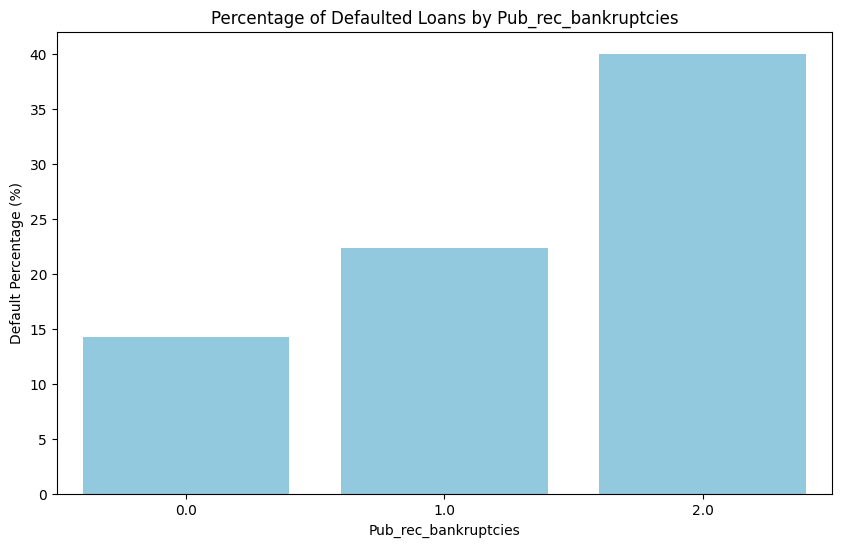

In [136]:
plot_default_percentage(df_filtered, 'sub_grade', 'loan_status', 'Charged Off')
plot_default_percentage(df_filtered, 'pub_rec_bankruptcies', 'loan_status', 'Charged Off')

<ipython-input-134-62e2025697c0>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_status_counts = df.groupby([category_column, status_column]).size().unstack(fill_value=0)


loan_status  Charged Off  Fully Paid  Default_Percent
term                                                 
36                  3227       25869        11.090872
60                  2400        7081        25.313785


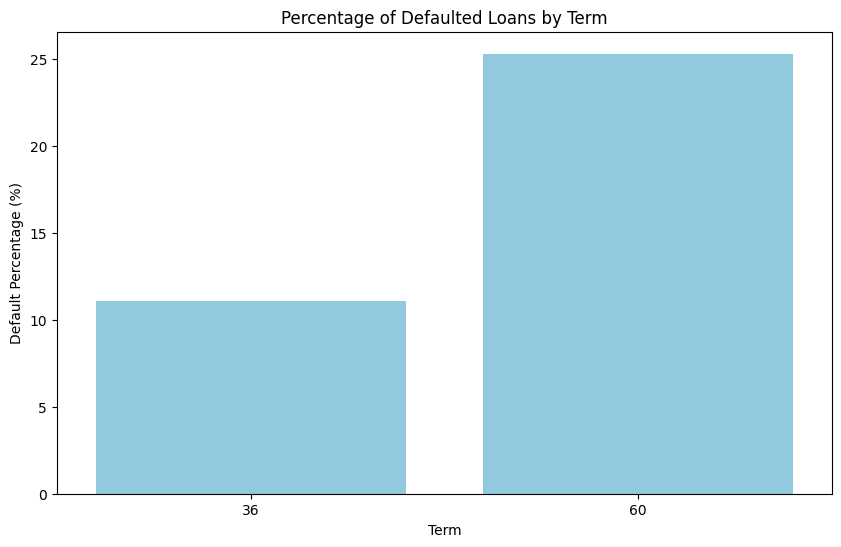

In [154]:
plot_default_percentage(df_filtered, 'term', 'loan_status', 'Charged Off')


We can say that people with high past record of bankrutcies mostly like ly to dfault
::

# Bivariate Analsyis with numerica vs numerical columns

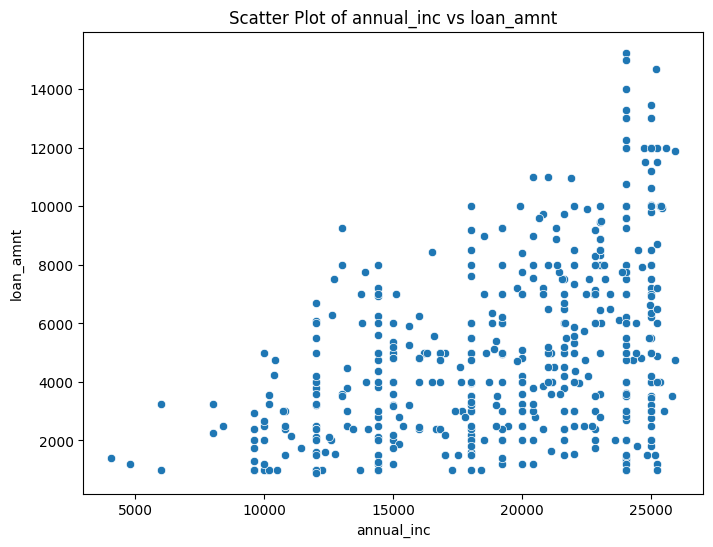

Correlation between annual_inc and loan_amnt: 0.4292609618866716


In [138]:

def bivariate_analysis_numerical(df, col1, col2):
  """
  Performs bivariate analysis between two numerical columns in a DataFrame.

  Args:
      df (pd.DataFrame): The DataFrame containing the data.
      col1 (str): The name of the first numerical column.
      col2 (str): The name of the second numerical column.
  """

  plt.figure(figsize=(8, 6))
  sns.scatterplot(x=col1, y=col2, data=df)
  plt.title(f'Scatter Plot of {col1} vs {col2}')
  plt.xlabel(col1)
  plt.ylabel(col2)
  plt.show()

  correlation = df[col1].corr(df[col2])
  print(f"Correlation between {col1} and {col2}: {correlation}")

  # You can also add other metrics like regression line, etc.
  # For example:
  # sns.regplot(x=col1, y=col2, data=df)


# Example Usage:
# Assuming you have a DataFrame 'df' and you want to analyze the relationship between 'loan_amnt' and 'annual_inc'
bivariate_analysis_numerical(df_filtered_charged[df_filtered_charged['annual_inc']<26000],  'annual_inc','loan_amnt')

Most people  with low annual have applied for high amoutn loans and not able to pay dues


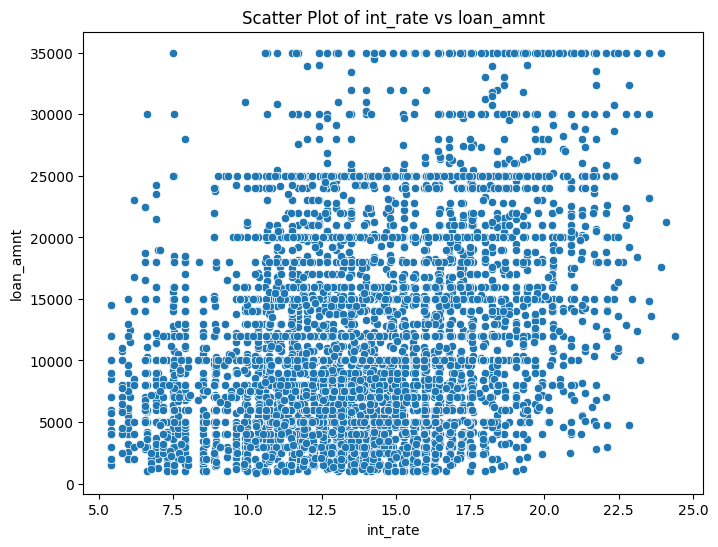

Correlation between int_rate and loan_amnt: 0.35121553277912587


In [139]:
bivariate_analysis_numerical(df_filtered_charged,  'int_rate','loan_amnt')

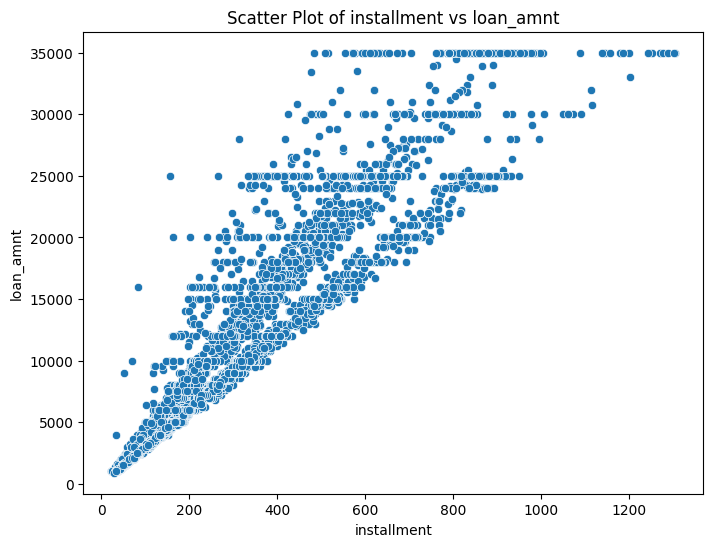

Correlation between installment and loan_amnt: 0.925911435558519


In [140]:
bivariate_analysis_numerical(df_filtered_charged,  'installment','loan_amnt')

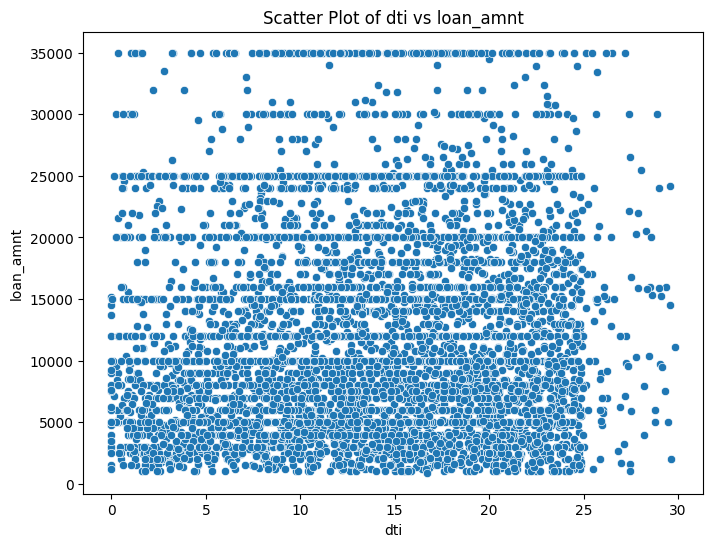

Correlation between dti and loan_amnt: 0.06387209208993694


In [141]:
bivariate_analysis_numerical(df_filtered_charged,  'dti','loan_amnt')

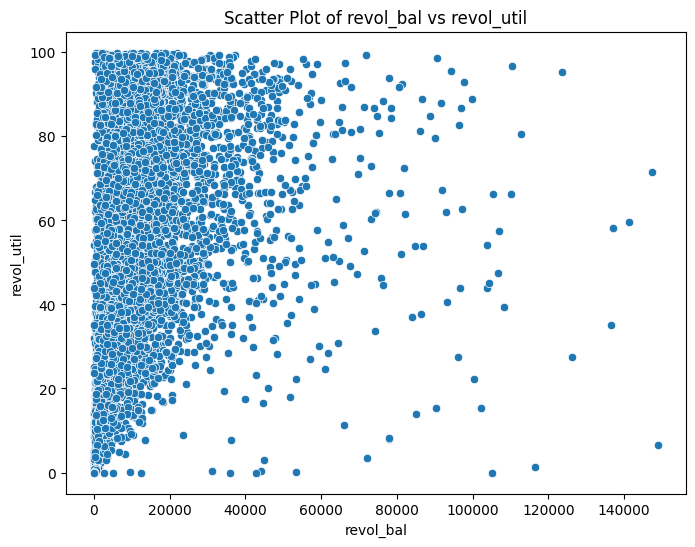

Correlation between revol_bal and revol_util: 0.2843874490820577


In [142]:
bivariate_analysis_numerical(df_filtered_charged,  'revol_bal','revol_util')

#Bivariate analysis Numerical column vs caetgorical


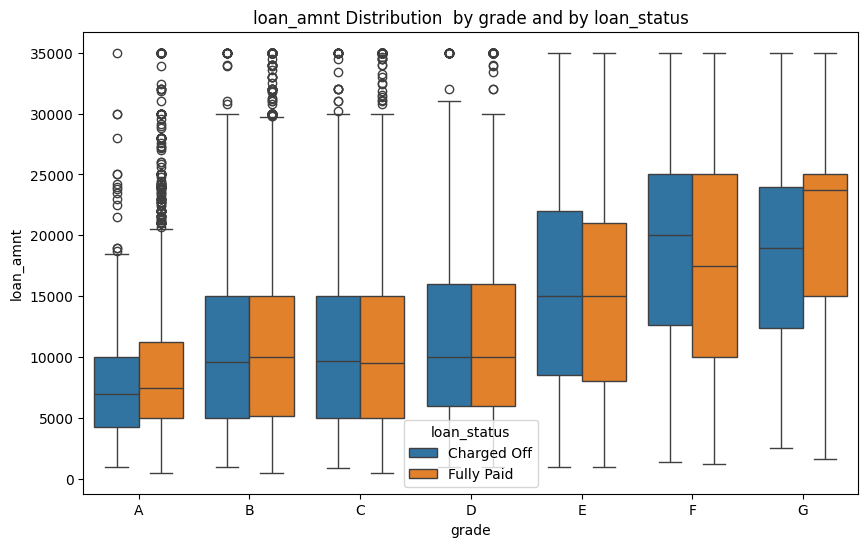

In [143]:

def bivariate_analysis_numerical_categorical(df1, numerical_col, categorical_col,hue = 'loan_status'):
  """
  Performs bivariate analysis between a numerical column and a categorical column in a DataFrame.

  Args:
      df (pd.DataFrame): The DataFrame containing the data.
      numerical_col (str): The name of the numerical column.
      categorical_col (str): The name of the categorical column.
  """

  plt.figure(figsize=(10, 6))
  sns.boxplot(x=categorical_col, y=numerical_col, data=df1,hue=hue)
  plt.title(f'{numerical_col} Distribution  by {categorical_col} and by {hue}')
  plt.xlabel(categorical_col)
  plt.ylabel(numerical_col)
  plt.show()





bivariate_analysis_numerical_categorical(df_filtered, 'loan_amnt', 'grade')


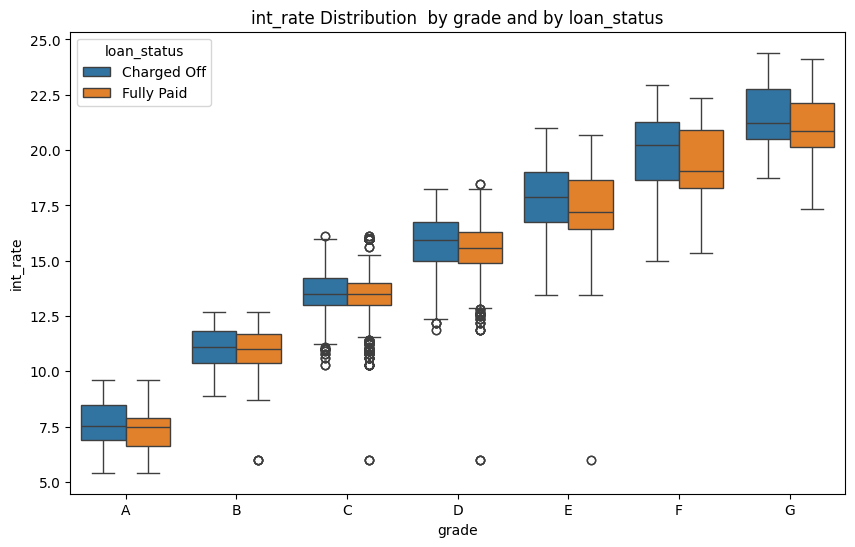

In [144]:
bivariate_analysis_numerical_categorical(df_filtered, 'int_rate', 'grade')
# we need to find other combinations with Grade that impact the default rate



* **Interest Rate and Grade:** As the loan grade increases from A to G, the interest rate also tends to increase. This is expected, as higher-risk borrowers are typically assigned lower grades and charged higher interest rates.


**Specific Insights:**

* **Lower-Grade Loans:** Lower-grade loans (D, E, F, G) have a higher median interest rate and a wider distribution, indicating a higher degree of risk associated with these borrowers.
* **Higher-Grade Loans:** Higher-grade loans (A, B, C) have a lower median interest rate and a narrower distribution, suggesting a lower risk profile for these borrowers.
* **Default Risk:** While the boxplots show some overlap, it appears that lower-grade loans might have a higher proportion of charged-off loans. However, other factors like income, employment, and economic conditions can also influence default risk.

**Implications for the Company:**

* **Risk Assessment:** The company can use this information to assess the risk associated with different loan grades. Lower-grade loans might require more stringent underwriting criteria and higher interest rates to compensate for the increased risk.


**Further Analysis:**

* **Income and Debt:** Analyzing the relationship between income, debt-to-income ratio, and loan grade can provide deeper insights into borrower financial health.
* **Loan Purpose:** Understanding the purpose of the loan for each loan grade can help identify specific risk factors.


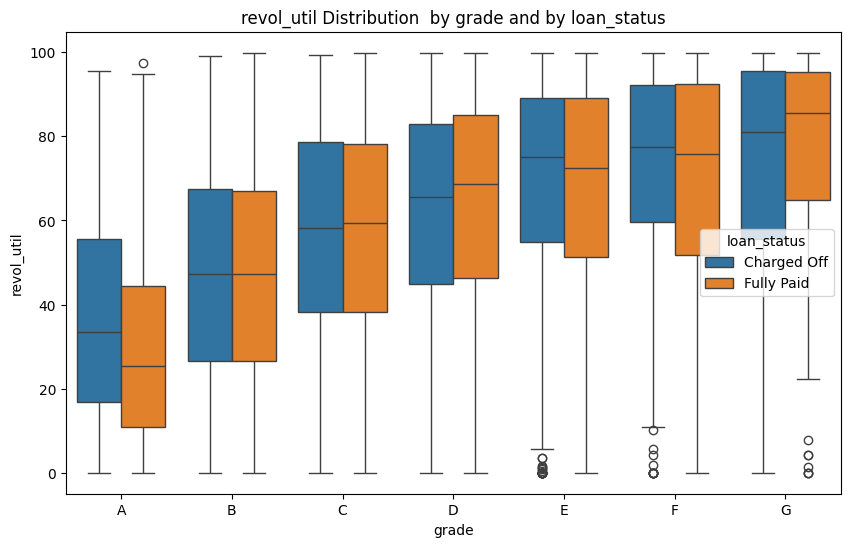

In [145]:
bivariate_analysis_numerical_categorical(df_filtered, 'revol_util', 'grade')


Revolving Utilization and Grade: As the loan grade increases from A to G, the median revolving utilization tends to increase. This suggests that borrowers with (higher grades F,G etc) tend to have higher levels of credit card debt relative to their credit limits.

# Combination of metrics


As the Grade Increase the  Charged off mean count also  increases ,so the business club should not approve higher loan amount when grades are high

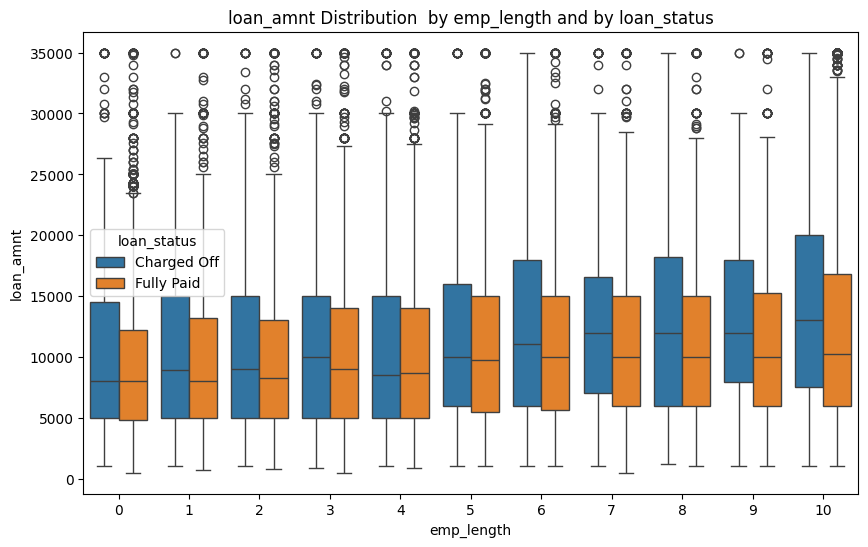

In [146]:
bivariate_analysis_numerical_categorical(df_filtered, 'loan_amnt', 'emp_length')

 While there is some variation, the overall trend suggests that longer employment lengths might be associated with slightly higher loan amounts. This could be due to higher income levels and better creditworthiness for individuals with longer employment histories.

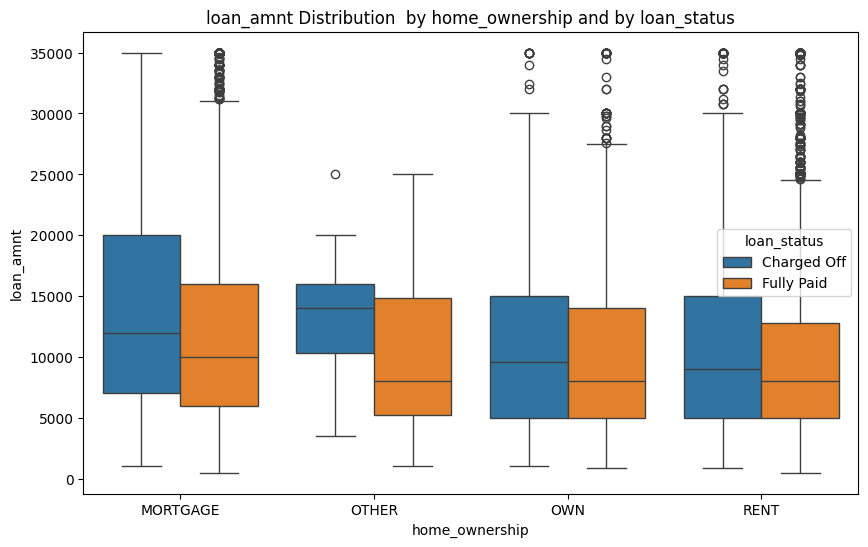

In [147]:
bivariate_analysis_numerical_categorical(df_filtered, 'loan_amnt', 'home_ownership')

This boxplot provides valuable insights into the relationship between home ownership status and loan amounts, as well as the potential impact on loan default.

Overall Observations:


Default Rates: The boxplots for charged-off and fully paid loans overlap for each home ownership category, indicating that default risk is not solely determined by home ownership.

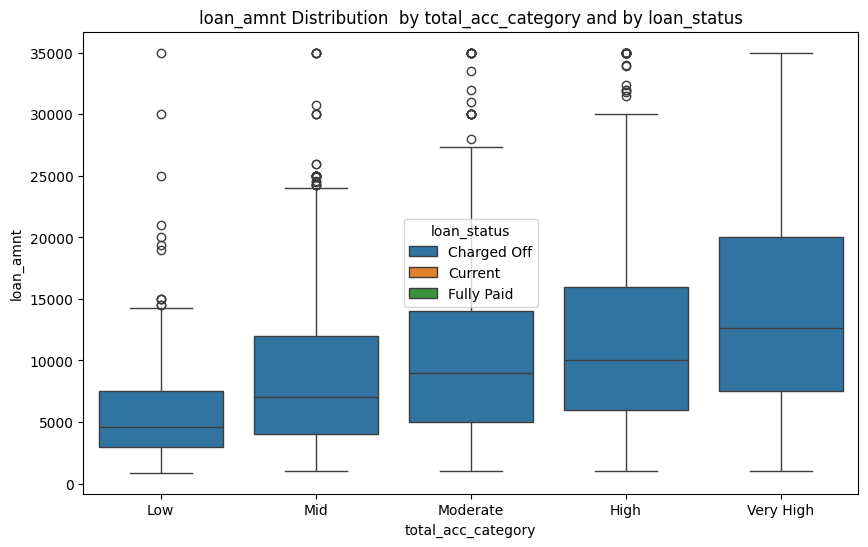

In [148]:
bivariate_analysis_numerical_categorical(df_filtered_charged, 'loan_amnt','total_acc_category')

Default Risk: While not a definitive conclusion, the slightly higher proportion of charged-off loans in the higher account categories suggests a potential link between a higher number of accounts and increased default risk. This could be due to factors like over-indebtedness or difficulty managing multiple credit obligations.

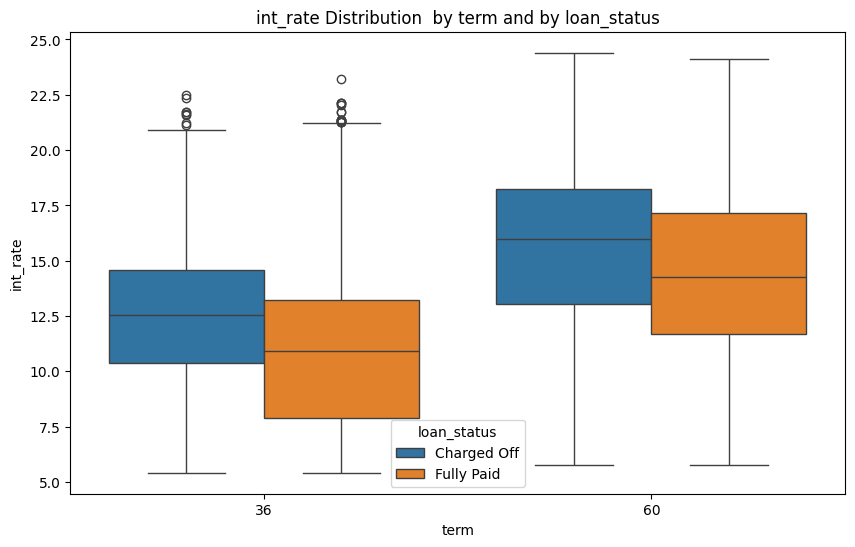

In [149]:
bivariate_analysis_numerical_categorical(df_filtered, 'int_rate', 'term')

###the people are paying high installment for in thier respoecivt  term loan  for chargefoof is higher than Full paid so there are  some others why iNterest rate is less
 - Or this might indicate Investor are  taking risk by giving them high interest rates

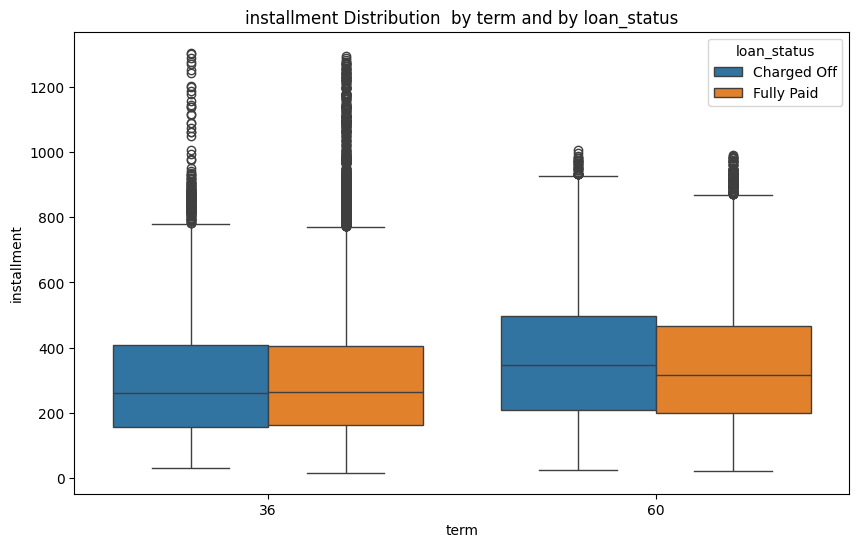

In [150]:
bivariate_analysis_numerical_categorical(df_filtered, 'installment', 'term')

# Bivaraiate analaysi of categorical to categorical with Loan Status

<Figure size 2000x1600 with 0 Axes>

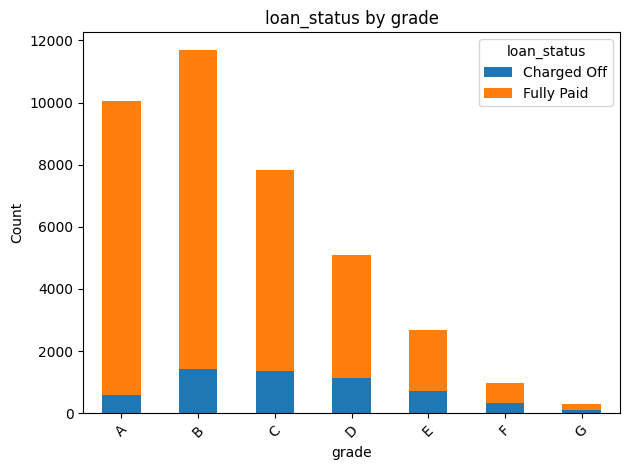

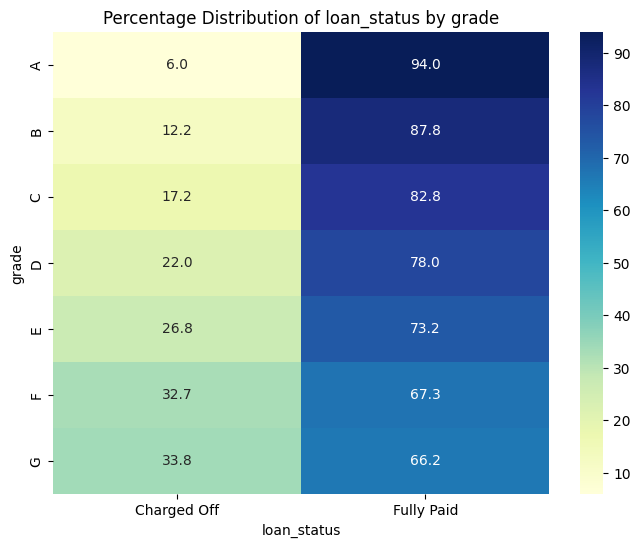

<Figure size 2000x1600 with 0 Axes>

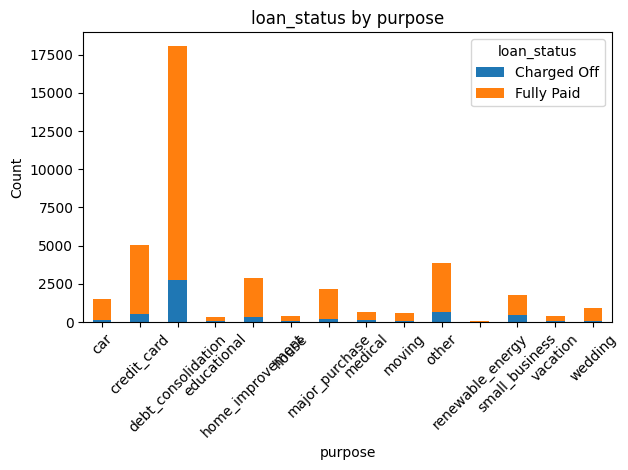

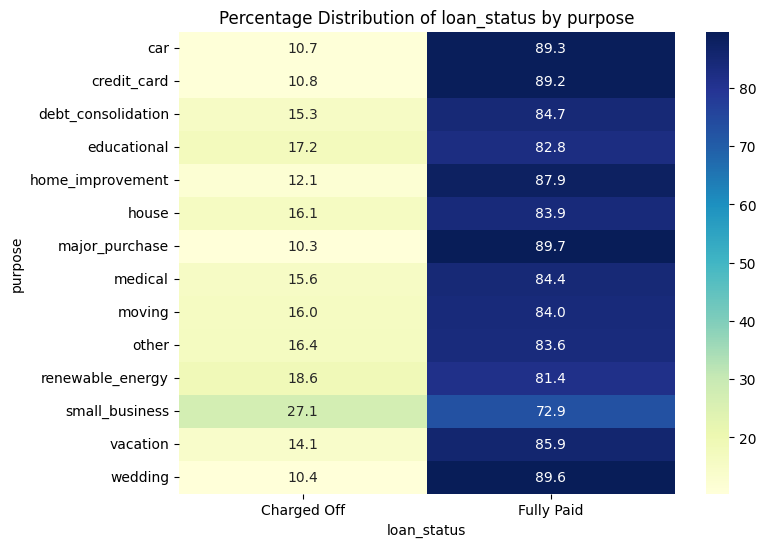

<Figure size 2000x1600 with 0 Axes>

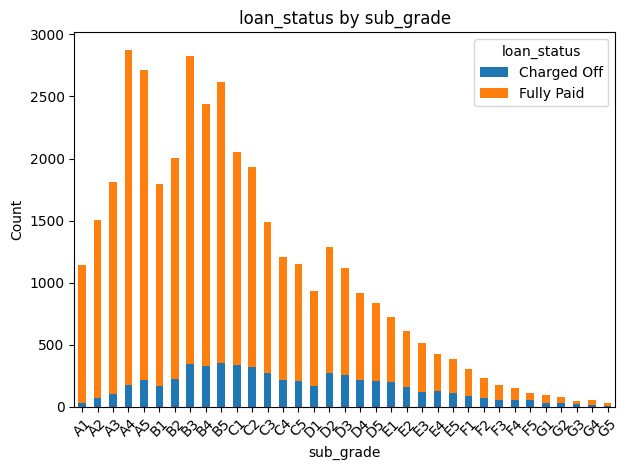

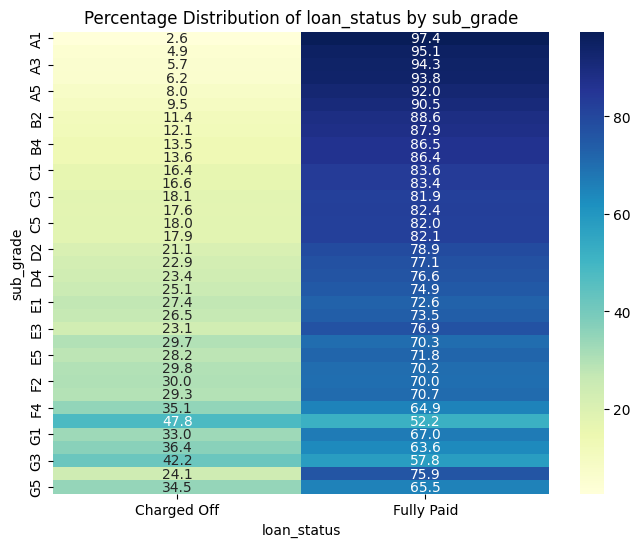

<Figure size 2000x1600 with 0 Axes>

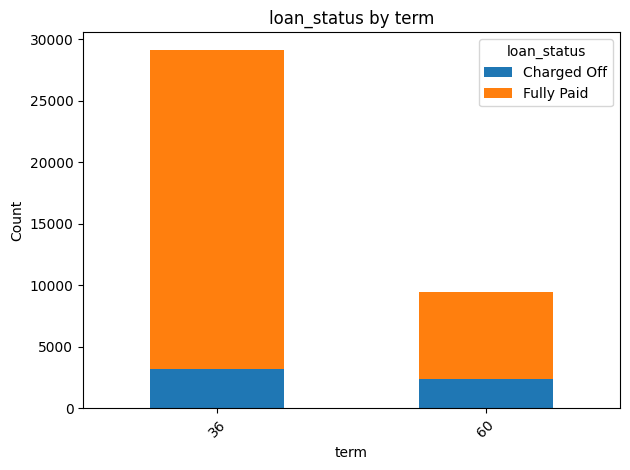

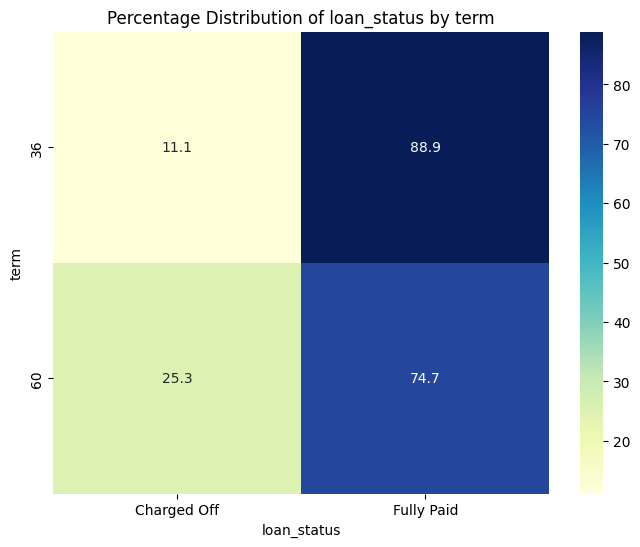

<Figure size 2000x1600 with 0 Axes>

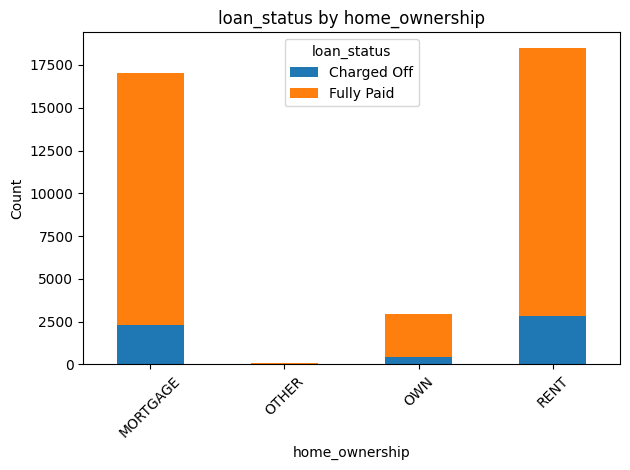

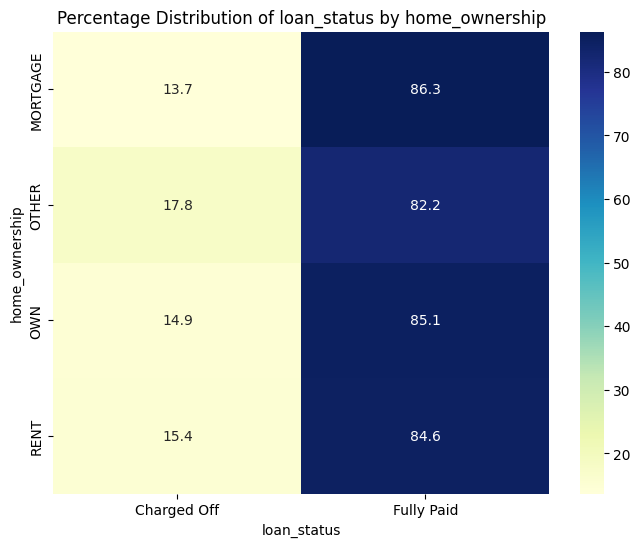

<Figure size 2000x1600 with 0 Axes>

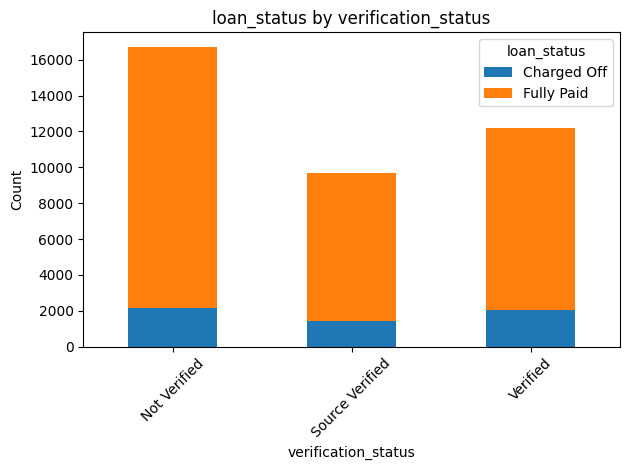

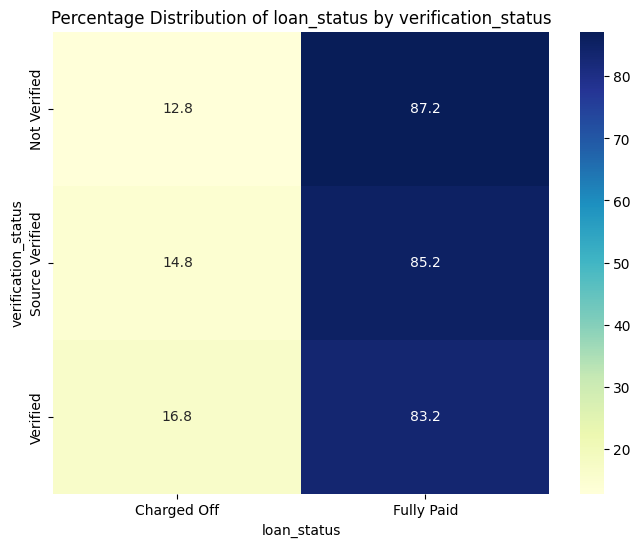

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def bivariate_analysis(df, cat_col1, cat_col2):
    """
    Perform bivariate analysis between two categorical variables.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    cat_col1 (str): The name of the first categorical column.
    cat_col2 (str): The name of the second categorical column.
    """

    # Step 1: Create a contingency table
    contingency_table = pd.crosstab(df[cat_col1], df[cat_col2], margins=True, margins_name="Total")

    # Step 2: Visualize with a stacked bar chart
    plt.figure(figsize=(20, 16))
    contingency_table.iloc[:-1, :-1].plot(kind='bar', stacked=True)
    plt.title(f'{cat_col2} by {cat_col1}')
    plt.xlabel(cat_col1)
    plt.ylabel('Count')
    plt.legend(title=cat_col2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Step 3: Calculate the percentage distribution of cat_col2 within cat_col1
    percentage_table = contingency_table.div(contingency_table['Total'], axis=0) * 100

    # Step 4: Create a heatmap of the percentage distribution
    plt.figure(figsize=(8, 6))
    sns.heatmap(percentage_table.iloc[:-1, :-1], annot=True, fmt=".1f", cmap='YlGnBu')
    plt.title(f'Percentage Distribution of {cat_col2} by {cat_col1}')
    plt.xlabel(cat_col2)
    plt.ylabel(cat_col1)
    plt.show()


df = df_filtered

# Call the function
# bivariate_analysis(df, 'grade', 'term')
# bivariate_analysis(df, 'grade', 'home_ownership')
bivariate_analysis(df, 'grade', 'loan_status')
bivariate_analysis(df, 'purpose', 'loan_status')
bivariate_analysis(df, 'sub_grade', 'loan_status')
bivariate_analysis(df, 'term', 'loan_status')
bivariate_analysis(df, 'home_ownership', 'loan_status')
bivariate_analysis(df, 'verification_status', 'loan_status')


# **MultiVariate**

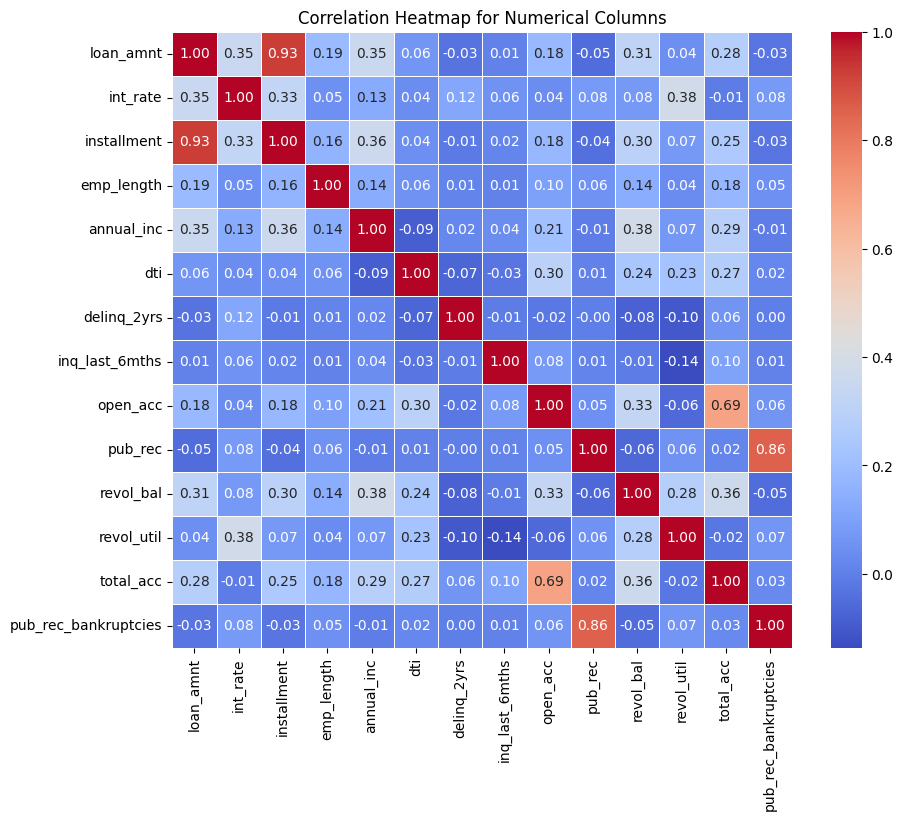

In [152]:

def plot_numerical_correlation_heatmap(df):
    """
    Plots a heatmap of the correlation matrix for numerical columns in a DataFrame.

    """

    # Select only the numerical columns
    numerical_df = df.select_dtypes(include=['number'])

    # Calculate the correlation matrix
    corr_matrix = numerical_df.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

    # Add title
    plt.title('Correlation Heatmap for Numerical Columns')
    plt.show()

plot_numerical_correlation_heatmap(df_filtered_charged)

#Summary




1. We can say that people with high past record of bankrutcies mostly like ly to default .
Percentage of Defaulted Loans incresaes by grade score decreases
2. There is a correlation between revolving Utilisation rate vs Loan grade Revolving Utilization and Grade: As the loan grade increases from A to G, the median revolving utilization tends to increase. This suggests that borrowers with (higher grades F,G etc) tend to have higher levels of credit card debt relative to their credit limits.
2. There is a postive  Correlation between Loan amount and Annual income.
3. This shows that most of defaulters are taking smaller loan amounts in range (5000-16000)  and max value is 35000
4.  There is a high frequency of values at 0 years and 10 years, suggesting that many applicants either have no employment history or have been employed for 10 or more years.
5. Most of defaultors were in low range of annual inc ,this is Negative Correlation
so this is a strong indicator were 50% of people income is below 60000
6. From this we can Categorize that as Category class  of total Accounts is increasing the default rate is increasing so the biininghere helped us to bin the customers based on the number of accounts

